# Load packages, functions

Please set path to modules, usually path2modules="./modules"

In [1]:
import math
import numpy as np
from numpy.linalg import inv
from numpy import sqrt as sqrt
from scipy.interpolate import griddata
from crystals import Crystal
import sys
path2modules="/home/lheller/python"
sys.path.append(path2modules)
from effective_elastic_constants_functions import  *
from projlib import  *
from crystallography_functions import *
from crystCalc import *
from plotlib import *
from scipy import interpolate
from wand.image import Image
from importlib import import_module 


Set paths for saving interactive graphs

In [ ]:
filepath="/home/lheller/Documents/papers/mypapers/AM_interface_under_stress/"
projectpath="/home/lheller/python/apps/straincomp/"
projecttemplate="/home/lheller/python/apps/straincomp/plotTemplate.py"


# Magic commands

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

# Lattice operators

## Cubic Austenite - parent phase
Austenite lattice matrix $\mathbf{L}^A=\begin{bmatrix}a^A&0&0\\0&a^A&0\\0&0&a^A\end{bmatrix}$ (denoted as LA in the code) is determined by lattice parameter of austenite $a^A$ (denoted as aA in the code).  Austenite lattice matrix converts Miller indexes of austenite lattice directions $\mathbf{m}_{d[uvw]}^A=[u^A,v^A,w^A]^{\sf T}$ into real space coordinates $\mathbf{x}_{d[uvw]}^A=[x^A,y^A,z^A]_{d[uvw]}^{\sf T}=\mathbf{L}^A\ \mathbf{m}_{d[uvw]}^A$.
<br>
Inverse austenite lattice matrix $\mathbf{L}_I^A={\mathbf{L}^A}^{-1}$ (denoted as LIA in the code) converts real space directions into Miller indexes of austenite lattice directions $\mathbf{m}_{d[uvw]}^A=\mathbf{L}_I^A\ \mathbf{x}_{d[uvw]}^A$.<br>
Austenite metric tensor $\mathbf{G}^A={\mathbf{L}^A}^{\sf T}\mathbf{L}^A$ (denoted as GA in the code) enables us to compute the square of the Euclidean norm of austenite lattice direction $||\mathbf{x}_{d[uvw]}^A||^2= {\mathbf{m}_{d[uvw]}^A}^{\sf T}\ \mathbf{G}^A\ \mathbf{m}_{d[uvw]}^A$.
<br><br>
Reciprocal austenite lattice matrix $\mathbf{L}_r^A={{\mathbf{L}^A}^{-1}}^{\sf T}$ (denoted as LrA in the code) converts Miller indexes of austenite lattice planes $\mathbf{m}_{p(hkl)}^A=[h^A,k^A,l^A]^{\sf T}$ into real space coordinates of planes normals $\mathbf{x}_{p(hkl)}^A=[x^A,y^A,z^A]_{p(hkl)}^{\sf T}=\mathbf{L}_r^A\ \mathbf{m}_{p(hkl)}^A$.<br>
Inverse reciprocal austenite lattice matrix $\mathbf{L}_{rI}^A={\mathbf{L}_r^A}^{-1}$ (denoted as LrIA in the code) converts real space plane normals into Miller indexes of austenite lattice planes $\mathbf{m}_{p(hkl)}^A=\mathbf{L}_{rI}^A\ \mathbf{x}_{p(hkl)}^A$.<br>
Austenite reciprocal metric tensor $\mathbf{G}_r^A={\mathbf{G}^A}^{-1}$ (denoted as GrA in the code) enables us to compute the square of the Euclidean norm of interplanar distance $||\mathbf{x}_{p(hkl)}^A||^2= {\mathbf{m}_{p(hkl)}^A}^{\sf T}\ \mathbf{G}_r^A\ \mathbf{m}_{p(hkl)}^A$.

In [3]:
#CIF file import for parent B2 structure
B2=Crystal.from_cif('/home/lheller/Documents/diffraction/cifs/NiTi - pm3m.cif')

#Direct and reciprocal symmetry operations for the point group of parent austenite phase
symopsA=[sym[0:3,0:3] for cc,sym in enumerate(B2.symmetry_operations())]
recsymopsA=[sym[0:3,0:3] for cc,sym in enumerate(B2.reciprocal_symmetry_operations())]


#lattice parameter in Angstroms
aA=B2.lattice_parameters[0]
#Bhattacharya, 2003
aA=3.015

#lattice matrix converting [uvw]->[xyz]
LA = aA*np.eye(3)

#inverse lattice matrix converting [xyz]->[uvw]
LIA = inv(LA)

#Meteric tensor ||[x,y,x]||^2=[uvw]^T*G_A*[uvw]
GA = np.matmul(LA.T,LA)

#Reciprocal Meteric tensor ||[x,y,x]||^2=d_hkl^2=[hkl]^T*Gr_A*[hkl]
GrA = inv(GA)

#reciprocal lattice matrix converting [hkl]->[xyz] 
LrA=inv(LA).T

#inverse lattice plane matrix converting [xyz]->[hkl] 
LrIA = inv(LrA)



In [4]:
#Check Metric Tensor
hkl_A=[1,1,2]

print("d-spacing of plane {} calculated by formula is {:0.5f}".format(\
str(hkl_A).replace('[','(').replace(']',')'),\
sqrt(aA**2/(hkl_A[0]**2+hkl_A[1]**2+hkl_A[2]**2))))
print("d-spacing of plane {} calculated by reciprocal metric tensor is {:0.5f}".format(\
str(hkl_A).replace('[','(').replace(']',')'),\
1./sqrt(np.array(hkl_A).dot(GrA.dot(hkl_A)))))
#d_cubic-1./sqrt(np.array(Parenthkl).dot(Parent_reciprocal_metric.dot(Parenthkl)))


d-spacing of plane (1, 1, 2) calculated by formula is 1.23087
d-spacing of plane (1, 1, 2) calculated by reciprocal metric tensor is 1.23087


## Monoclinic martensite - product phase

Martensite lattice matrix $\mathbf{L}^M=\begin{bmatrix}a^M&0&c^M\cos{\beta^M}\\0&b^M&0\\0&0&c^M\sin{\beta^M}\end{bmatrix}$
(denoted as LM in the code) is determined by lattice parameters of monoclinic martensite $a^M$, $b^M$, $c^M$, $\beta^M$ (denoted as aM,bM,cM,betaM in the code).  Martensite lattice matrix converts Miller indexes of martensite lattice directions $\mathbf{m}_{d[uvw]}^M=[u^M,v^M,w^M]^{\sf T}$ into real space coordinates $\mathbf{x}_{d[uvw]}^M=[x^M,y^M,z^M]_{d[uvw]}^{\sf T}=\mathbf{L}^M\ \mathbf{m}_{d[uvw]}^M$.
<br>
Inverse martensite lattice matrix $\mathbf{L}_I^M={\mathbf{L}^M}^{-1}$ (denoted as LIM in the code) converts real space directions into Miller indexes of martensite lattice directions $\mathbf{m}_{d[uvw]}^M=\mathbf{L}_I^M\ \mathbf{x}_{d[uvw]}^M$.<br>
Martensite metric tensor $\mathbf{G}^M={\mathbf{L}^M}^{\sf T}\mathbf{L}^M$ (denoted as GM in the code) enables us to compute the square of the Euclidean norm of martensite lattice direction $||\mathbf{x}_{d[uvw]}^M||^2= {\mathbf{m}_{d[uvw]}^M}^{\sf T}\ \mathbf{G}^M\ \mathbf{m}_{d[uvw]}^M$.
<br><br>
Reciprocal martensite lattice matrix $\mathbf{L}_r^M={{\mathbf{L}^M}^{-1}}^{\sf T}$ (denoted as LrM in the code) converts Miller indexes of martensite lattice planes $\mathbf{m}_{p(hkl)}^M=[h^M,k^M,l^M]^{\sf T}$ into real space coordinates of planes normals $\mathbf{x}_{p(hkl)}^M=[x^M,y^M,z^M]_{p(hkl)}^{\sf T}=\mathbf{L}_r^M\ \mathbf{m}_{p(hkl)}^M$.<br>
Inverse reciprocal martensite lattice matrix $\mathbf{L}_{rI}^M={\mathbf{L}_r^M}^{-1}$ (denoted as LrIM in the code) converts real space plane normals into Miller indexes of martensite lattice planes $\mathbf{m}_{p(hkl)}^M=\mathbf{L}_{rI}^M\ \mathbf{x}_{p(hkl)}^M$.<br>
Martensite reciprocal metric tensor $\mathbf{G}_r^M={\mathbf{G}^M}^{-1}$ (denoted as GrM in the code) enables us to compute the square of the Euclidean norm of interplanar distance $||\mathbf{x}_{p(hkl)}^M||^2= {\mathbf{m}_{p(hkl)}^M}^{\sf T}\ \mathbf{G}_r^M\ \mathbf{m}_{p(hkl)}^M$.



In [5]:
#CIF file import for product martensite B19p structure
B19p=Crystal.from_cif('/home/lheller/Documents/diffraction/cifs/NiTiB19p.cif')

#Direct and reciprocal symmetry operations for the point group of product martensite phase
symopsM=[sym[0:3,0:3] for cc,sym in enumerate(B19p.symmetry_operations()) if cc in [0,1]]
recsymopsM=[sym[0:3,0:3] for cc,sym in enumerate(B19p.reciprocal_symmetry_operations()) if cc in [0,1]]


#lattice parameter in Angstroms
betaM= B19p.lattice_parameters[4]*np.pi/180;
aM = B19p.lattice_parameters[2];
bM= B19p.lattice_parameters[1];
cM= B19p.lattice_parameters[0];
#Bhattacharya, 2003
betaM= 96.8*np.pi/180;
aM = 2.889;
bM= 4.12;
cM= 4.622;
#Cayron https://www.sciencedirect.com/science/article/pii/S0749641922002467?via%3Dihub#eqn0001
#betaM=96.8*np.pi/180;
#aM = 2.89;
#bM= 4.12;
#cM= 4.63;


#lattice matrix converting [uvw]->[xyz]
LM = np.array([[aM,0,cM*np.cos(betaM)],[0,bM,0],[0,0,cM*np.sin(betaM)]])

#inverse lattice matrix converting [xyz]->[uvw]
LIM = inv(LM)

#Meteric tensor ||[x,y,x]||^2=[uvw]^T*G_M*[uvw]
GM = np.matmul(LM.T,LM)

#Reciprocal Meteric tensor ||[x,y,x]||^2=d_hkl^2=[hkl]^T*Gr_M*[hkl]
GrM = inv(GM)

#reciprocal lattice matrix converting [hkl]->[xyz] 
LrM=inv(LM).T


#inverse lattice plane matrix converting [xyz]->[hkl] 
LrIM = inv(LrM)


In [6]:
#Check Metric Tensor
hkl_M=[4,1,2]

print("d-spacing of plane {} calculated by formula is {:0.5f}".format(\
str(hkl_M).replace('[','(').replace(']',')'),\
sqrt(1/(1/np.sin(betaM)**2*(hkl_M[0]**2/aM**2+\
                          hkl_M[1]**2*np.sin(betaM)**2/bM**2+hkl_M[2]**2/cM**2-\
                          2*hkl_M[0]*hkl_M[2]*np.cos(betaM)/aM/cM)))))
print("d-spacing of plane {} calculated by reciprocal metric tensor is {:0.5f}".format(\
str(hkl_M).replace('[','(').replace(']',')'),\
1./sqrt(np.array(hkl_M).dot(GrM.dot(hkl_M)))))
#d_cubic-1./sqrt(np.array(Parenthkl).dot(Parent_reciprocal_metric.dot(Parenthkl)))

d-spacing of plane (4, 1, 2) calculated by formula is 0.65414
d-spacing of plane (4, 1, 2) calculated by reciprocal metric tensor is 0.65414


# Lattice correspondence
Corespondance matrices for directions $\mathbf{C}_d^{M\xrightarrow i A}$ (denoted as Cd in the code) mapping martensite lattice directions $\mathbf{m}_{d[uvw]}^M$ into austenite ones $\mathbf{m}_{d[u_iv_iw_i]}^A$ and inversely using matrices $\mathbf{C}_d^{A\xrightarrow i M}={\mathbf{C}_d^{M\xrightarrow i A}}^{-1}$ (denoted as CId in the code), where $i=1\ldots 12$ denotes correspondence variants.<br>
similarly, for lattice plane normals. Corespondance matrices for planes $\mathbf{C}_p^{M\xrightarrow i A}$ (denoted as Cp in the code) mapping martensite lattice directions $\mathbf{m}_{p(hkl)}^M$ into austenite ones $\mathbf{m}_{p(h_ik_il_i)}^A$ and inversely using matrices $\mathbf{C}_p^{A\xrightarrow i M}={\mathbf{C}_p^{M\xrightarrow i A}}^{-1}$ (denoted as CIp in the code), where $i=1\ldots 12$ denotes correspondence variants.

In [7]:
Cd, CId, Cp, CIp = B19p_B2_lattice_correspondence(notation='Waitz')

# Deformation gradients between stress-free austenite and 12 variants of martensite
Deformation gradient $\mathbf{F^A}$ and its polar decomposition into stretch matrix $\mathbf{U^A}$ and rotational part $\mathbf{Q^A}$. Deformation gradients maps vectors of referential austenite $[xyz]_A$ into their transfomed counterpart in martensite vectors  $[xyz]_M$, i.e. $[xyz]_M^\mathrm{T}=\mathbf{F^A}[xyz]_A^\mathrm{T}$. Matrices of coordinate system change from austenite reference frame to martensite frame $\mathbf{T^{AM}}$ and vice-versa $\mathbf{T^{MA}}$

In [8]:
#Cleaned function
F_AM, U_AM, Q_M, T_MA, T_AM=def_gradient_stressfree(Cd,LA, LM)#CId=CId)

# Set plotting variables

In [164]:
#Type of projection - stereographic or equalarea
ProjType='equalarea'
#ProjType='stereo'
#Setting of monoclinic projection
#  - x || [100], y || [010], z || (001)
x=LM.dot([1,0,0])
x=x/sqrt(x.dot(x))
y=LM.dot([0,1,0])
y=y/sqrt(y.dot(y))
z=LrM.dot([0,0,1])
z=z/sqrt(z.dot(z))

if False:
    x=LrM.dot([1,0,0])
    x=x/sqrt(x.dot(x))
    y=LrM.dot([0,1,0])
    y=y/sqrt(y.dot(y))
    z=LM.dot([0,0,1])
    z=z/sqrt(z.dot(z))


#assign projection transformation matrix according to the setting
ProjT=np.array([x,y,z])
#assign projection type (either "equalarea" or "stereo" for stereographic)
#


In [107]:

attributes={}
attributes['cbartitle']="Stress [MPa]"

attributes['cmap']='jet'
#attributes['textlim']=-10
attributes['contourcol']='dimgray'
attributes['printcorrespondent']=True
attributes['correspdelim']='\n'
#attributes['cbarh']=0.015
attributes['ProjType']=ProjType
#vmbar=None,cbarh=0.04, cbarwfac=0.75,cbarhshift=-0.15
#Attribute for austenite projection
attributesA={}
attributesA['printasfamily']=True
attributesA['printcorrespondent']=False
attributesA['printcorrespondentpoints']=False
attributesA['cbarhshift']=-0.1
attributesA['LPhase1']=LA
attributesA['LrPhase1']=LrA
attributesA['LPhase2']=LM
attributesA['LrPhase2']=LrM
attributesA['printasfamily']=True
attributesA['R2Proj']=np.eye(3)
attributesA['symops']=[symopsA[0]]
attributesA['recsymops']=[symopsA[0]]
attributesA['sphere']='triangle'
attributesA['stereomesh']=True
attributesA['phase1']="A"#"B2"#'A'
attributesA['phase2']="M"#"B19'"#'M'
attributesA['dirs']=[[0,0,1],[1,0,1],[1,1,2],[2,1,2],[1,1,1]]
#attributesA['dirs']=[[1,0,0],[1,1,0],[2,1,1],[2,2,1],[1,1,1]]
dirtexthiftsi={}
dirtexthiftsi['112']=[-0.08,0]
dirtexthiftsi['212']=[0.03,0]
#dirtexthifts['211']=[-0.08,0]
#dirtexthifts['221']=[0.03,0]
normtexthiftsi={}
attributesA['dirtexthifts']=dirtexthiftsi
attributesA['normtexthifts']=normtexthiftsi
attributesA['Cd']=CId
attributesA['Cp']=CIp
attributesA['varsel']=0
attributesA['T']=T_MA



#Attributes for martensite projection
attributesM={}
attributesM['printasfamily']=False
attributesM['printcorrespondent']=True
attributesM['printcorrespasfamily']=False
attributesM['cbarhshift']=-0.15
attributesM['LPhase1']=LM
attributesM['LrPhase1']=Lr=LrM
attributesM['LPhase2']=LA
attributesM['LrPhase2']=LrA
attributesM['R2Proj']=ProjT
attributesM['symops']=symopsM
attributesM['recsymops']=recsymopsM
attributesM['sphere']='half'
attributesM['phase1']="M"#"B19'"#'M'
attributesM['phase2']="A"#"B2"#'A'
attributesM['dy1']=-0.27
attributesM['dy2']=-0.25
attributesM['dirs']=[[1,0,0],[0,1,0],[0,0,1],[0,1,1],[1,1,0],[-1,1,0],[1,1,1],[4,0,1],
                     [-1,1,1],[-1,0,2],[1,0,2],[-1,0,1],[1,0,1],[2,1,1],[-2,1,1],[0,1,3]]
attributesM['norms']=[[0,0,1]]
attributesM['printcorrespascubicfamily']=True
attributesM['printcorrespasfamily']=True
attributesM['printcorrespondentpoints']=True
dirtexthiftsi={}
normtexthiftsi={}
dirtexthiftsi['-110']=[-0.3,0]
dirtexthiftsi['-111']=[-0.3,0.3]
dirtexthiftsi['-101']=[-0.25,0.]
dirtexthiftsi['-102']=[-0.1,0.0]
dirtexthiftsi['001']=[-0.02,0.0]
dirtexthiftsi['101']=[0.05,0.0]
dirtexthiftsi['-100']=[-0.2,0.0]
dirtexthiftsi['-211']=[-0.35,0.05]
dirtexthiftsi['011']=[-0.05,0.0]
dirtexthiftsi['111']=[-0.1,0.0]
dirtexthiftsi['211']=[-0.1,0.0]
dirtexthiftsi['013']=[-0.35,0.25]
dirtexthiftsi['401']=[-0.05,0.]

normtexthiftsi['001']=[-0.02,0.3]

attributesM['dirtexthifts']=dirtexthiftsi
attributesM['normtexthifts']=normtexthiftsi
attributesM['Cd']=Cd
attributesM['Cp']=Cp
attributesM['varsel']=0
attributesM['T']=T_AM


# Elastic Properties of austenite and martensite

## Cubic Austenite - parent phase

In [165]:
C11=169e3
C12=141e3
C44=33e3

A=2*C44/(C11-C12)


parent_elastic_constants={'11':C11,'22':C11,'33':C11,'12':C12,'13':C12,'23':C12,'44':C44,'55':C44,'66':C44}


CA = stiffness_matrix(parent_elastic_constants)
CTA=stiffness_from_voight_notation2tensor(CA)
SA = inv(CA)
STA = compliance_from_voight_notation2tensor(np.linalg.inv(CA))
print(f"Stifness matrix of parent austenite in Voigt notation:\n{CA}")

Stifness matrix of parent austenite in Voigt notation:
[[169000. 141000. 141000.      0.      0.      0.]
 [141000. 169000. 141000.      0.      0.      0.]
 [141000. 141000. 169000.      0.      0.      0.]
 [     0.      0.      0.  33000.      0.      0.]
 [     0.      0.      0.      0.  33000.      0.]
 [     0.      0.      0.      0.      0.  33000.]]


## Elastic properties of martensite

In [166]:
#Martensite elastic constants Wagner https://www.sciencedirect.com/science/article/pii/S1359645408006083
CM_11=223e3;
CM_12=129e3;
CM_13=99e3;
CM_15=27e3;
CM_22=241e3;
CM_23=125e3;
CM_25=-9e3;
CM_33=200e3;
CM_35=4e3;
CM_44=76e3;
CM_46=-4e3;
CM_55=21e3;
CM_66=77e3;
#%Martensite elastic constants Sestak
#% CM_11=188;
#% CM_12=122;
#% CM_13=89;
#% CM_15=14;
#% CM_22=231;
#% CM_23=108;
#% CM_25=-10;
#% CM_33=245;
#% CM_35=25;
#% CM_44=77;
#% CM_46=-12;
#% CM_55=45;
#% CM_66=90;
#
#%Martensite elastic constants Hatcher I
#% CM_11=249;
#% CM_12=129;
#% CM_13=107;
#% CM_15=15;
#% CM_22=245;
#% CM_23=125;
#% CM_25=-3;
#% CM_33=212;
#% CM_35=-1;
#% CM_44=87;
#% CM_46=-4;
#% 
#% %%%%%%%%%%%%%%
#% %critical
#% CM_55=66;
#% %%%%
#% 
#% CM_66=86;
#% 

constants={'11':CM_11,'12':CM_12,'13':CM_13,'15':CM_15,\
           '22':CM_22,'23':CM_23,'25':CM_25,\
            '33':CM_33,'35':CM_35,\
           '44':CM_44,'46':CM_46,\
           '55':CM_55,'66':CM_66}


CM = stiffness_matrix(constants)

CTM=stiffness_from_voight_notation2tensor(CM)
SM = inv(CM)
STM = compliance_from_voight_notation2tensor(SM)

# Setup crystallographic calculator

In [246]:
#Create object
MT=calcMT()
#Fill in lattice matricesof austenite (LA) and martensite (LM)
MT.setLatticeMatrices(LA,LM)
#Fill in lattice correspondence
MT.setLatticeCorrespondence(Cd,CId=CId)
MT.setLatticeCorrespondencePlanes(Cp,CIp=CIp)
#Fill in tensors of elastic compliances of austenite (STA) and martensite (STM)
MT.setTensorsOfElastCompliance(STA,STM)
MT.getStressfreeDefGrads()

# Directional Young's modulus of parent austenite phase and product martensite phase

## Directional Young's modulus of parent austenite phase

/usr/local/lib/python3.10/dist-packages/diffsims/generators/sphere_mesh_generators.py:515: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


Min. modulus - 40.73548387096774, along [0. 0. 1.] direction.
Max. modulus - 92.25000000000003, along [1. 1. 1.] direction.


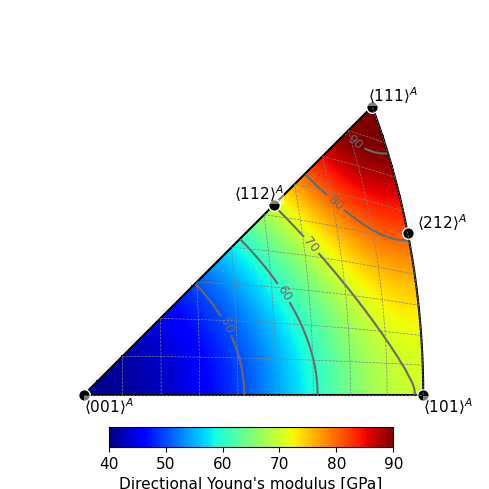

In [248]:
#size of the graph
plt.rcParams['figure.figsize'] = [12/2.45,12/2.45]
SMALL_SIZE=11
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

SAVE=False
crop=True
imformats=['png','svg','pdf']
figname=f'{filepath}figures/fig01_EA_{ProjType}.pdf'

#Generate a set of orientations in the space of stereotriangle
oris=genoritri(resolution=1,mesh="spherified_cube_edge")
#Generate directional Young's modulus along all orientations within the set
EA=MT.dirModulus(MT.STA,oris)
EA=EA/1000
print('Min. modulus - {}, along {} direction.'.format(np.min(EA),vector2miller(LIA.dot(oris[:,np.argmin(EA)]))) )
print('Max. modulus - {}, along {} direction.'.format(np.max(EA),vector2miller(LIA.dot(oris[:,np.argmax(EA)]))) )
SAVE=True
vm=[40,90]
ticks=ticks=np.linspace(vm[0],vm[1],6)
cbartitle="Directional Young's modulus [GPa]"
plotter1=plotter()
for attrib in [attributes,attributesA]:
    plotter1.__dict__.update(attrib)
plotter1.plotProj()
plotter1.plotDirsNorms()
plotter1.plotColormap(oris=oris,colmapdata=EA,vm=vm,ticks=ticks,nump=301)
plotter1.plotColorbar(cbartitle=cbartitle)
plotter1.dataShow()
plotter1.dataAnnot()
if SAVE:
    plotter1.figsave(fname=figname,imformats=imformats,crop=crop)

## Directional Young's modulus of product martensite phase

In [249]:
#Create object
MT=calcMT()
#Fill in lattice matricesof austenite (LA) and martensite (LM)
MT.setLatticeMatrices(LA,LM)
#Fill in lattice correspondence
MT.setLatticeCorrespondence(Cd,CId=CId)
MT.setLatticeCorrespondencePlanes(Cp,CIp=CIp)
#Fill in tensors of elastic compliances of austenite (STA) and martensite (STM)
MT.setTensorsOfElastCompliance(STA,STM)
MT.getStressfreeDefGrads()

#Generate orientations in space in our settings - we transfom orientations in the standard coordinate system of the lattice to our setting for projection plotting
oris=genori(dangle=1,hemi='upper', half='upper',rot=ProjT)

#Get directional modulus - it is calculated in the standard coordinate system of the lattice, we have to transform back the orientations 
EM=MT.dirModulus(MT.STM,ProjT.T.dot(oris))
EM=EM/1000
print('Min. modulus - {}, along {} direction.'.format(np.min(EM),vector2miller(LIM.dot(oris[:,np.argmin(EM)]))) )
print('Max. modulus - {}, along {} direction.'.format(np.max(EA),vector2miller(LIM.dot(oris[:,np.argmax(EM)]))) )

#Get corresponding Young's modulus of austenite - has to be calculated on the same grid that is just rotated with respect to martensite according to lattice correspondence
EA=MT.dirModulus(MT.STA,MT.StressfreeDefGrads['T_MA'][:,:,0].dot(oris))
EA=EA/1000


Min. modulus - 33.19525307900164, along [-1.772  0.     1.   ] direction.
Max. modulus - 92.25000000000003, along [-1.     5.616  4.233] direction.


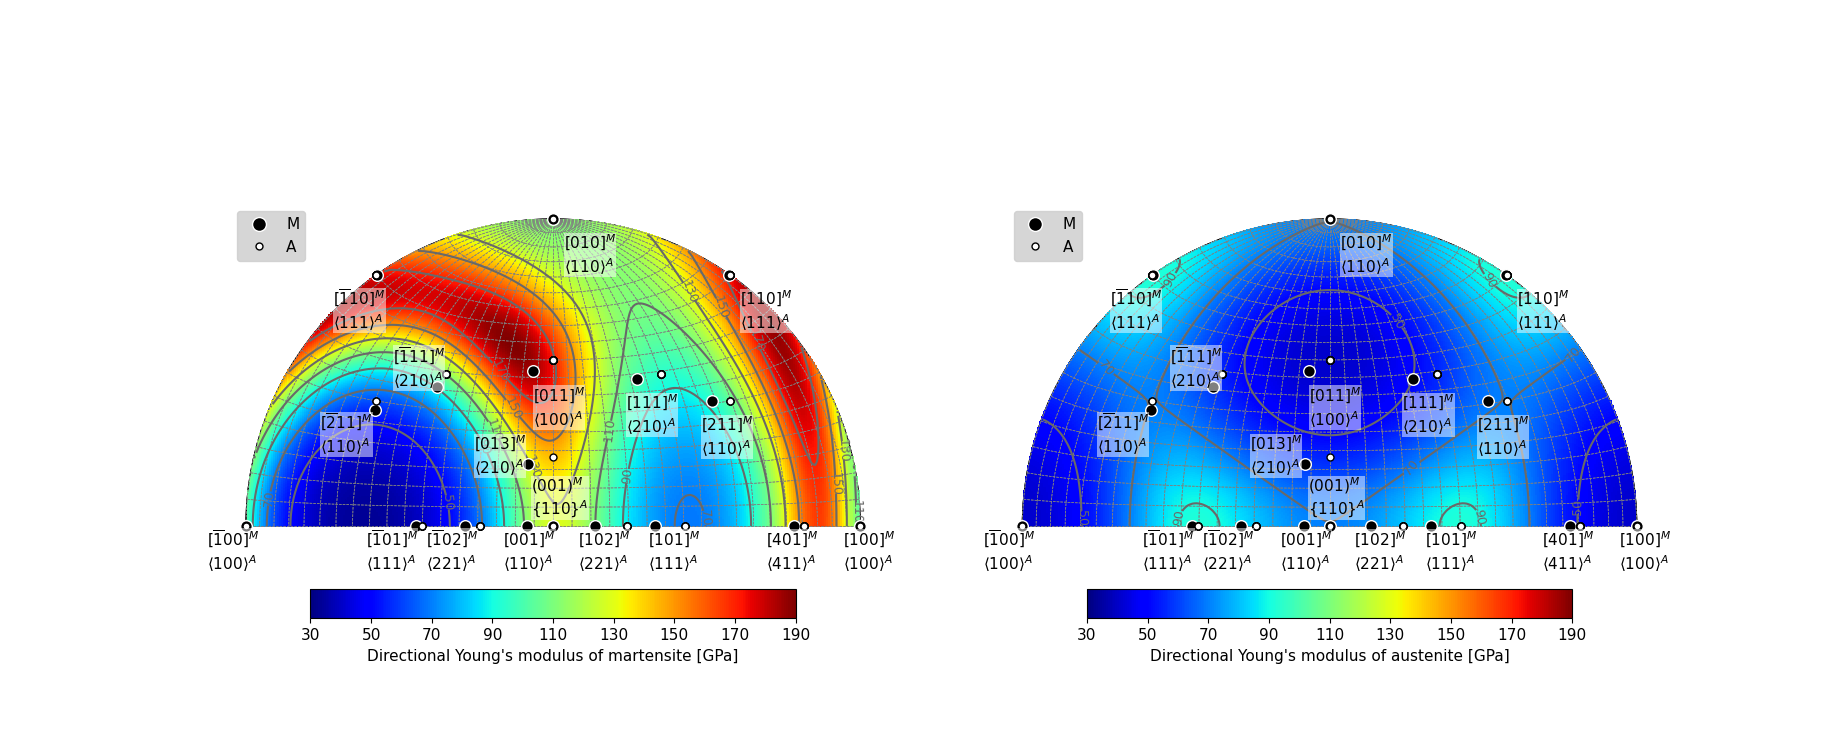

In [250]:
#size of the graph
plt.rcParams['figure.figsize'] = [45/2.45, 18/2.45]
SMALL_SIZE=11
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
SAVE=False
crop=True
imformats=['png','svg','pdf']
figname=f'{filepath}figures/fig02_EM_{ProjType}_graphtype.pdf'
vm=[30,190]
ticks=np.linspace(vm[0],vm[1],9)
cbartitle="Directional Young's modulus of martensite [GPa]"
data2plot=[]
data2plot.append({'oris':oris,
                  'colmapdata':EM,'cbartitle':cbartitle,'vm':vm,#'datadeviders':DataDeviders,
                  'cmap':'jet','graphtype':'martensite',
                  'ticks':np.linspace(vm[0],vm[1],9),'contourcol':'dimgray','figsize':[16/2.45, 15/2.45]})
cbartitle="Directional Young's modulus of austenite [GPa]"
data2plot.append({'oris':oris,
                  'colmapdata':EA,'cbartitle':cbartitle,'vm':vm,#'datadeviders':DataDeviders,
                  'cmap':'jet','graphtype':'austenite',
                  'ticks':np.linspace(vm[0],vm[1],9),'contourcol':'dimgray','figsize':[16/2.45, 15/2.45]})
attributes2use=[]
attributes2use4save=[]
showdat={}
showdhalf={'showdatanames':["Directional Young's modulus of martensite [GPa]","Directional Young's modulus of austenite [GPa]"]
           ,'showdata':[EM,EA]}

dirtexthifts['-110']=[-0.25,0]
dirtexthifts['-111']=[-0.25,0.25]
dirtexthifts['-101']=[-0.15,0.]
dirtexthifts['-102']=[-0.1,0.0]
dirtexthifts['001']=[-0.03,0.0]
dirtexthifts['101']=[0.05,0.0]
dirtexthifts['-100']=[-0.1,0.0]
dirtexthifts['-211']=[-0.3,0.05]
dirtexthifts['011']=[-0.05,0.0]
dirtexthifts['111']=[-0.1,0.0]
dirtexthifts['211']=[-0.1,0.0]
dirtexthifts['013']=[-0.3,0.2]

normtexthifts['001']=[-0.02,0.25]

if not SAVE:
    atributesADD={'dirtexthifts':dirtexthifts,'normtexthifts':normtexthifts,'printcorrespasfamily':True,'cbarhshift':-0.15,'dy1':-0.2}
else:
    atributesADD={'printcorrespasfamily':True,'cbarhshift':-0.15,'dy1':-0.2}
attributes2use.append([attributes,attributesM,showdhalf,atributesADD])
attributes2use.append([attributes,attributesM,showdhalf,atributesADD])
attributes2use4save.append({'dy1':-0.25})#'cbarh':0.025,'cbarhshift':-0.08})
attributes2use4save.append({'dy1':-0.25})#'cbarh':0.025,'cbarhshift':-0.08})
colormapdatas=[None,None]
withdraw=False
code="""
PP=[]
if not SAVE:
    fig, AX = plt.subplots(1,2)
try:
    attributes2use4save
except:
    attributes2use4save=attributes2use
for data,attribs,colormapdata,attrib4save in zip(data2plot,attributes2use,colormapdatas,attributes2use4save):
    PP.append(plotter())
    for attrib in attribs:
        PP[-1].__dict__.update(attrib)
    PP[-1].__dict__.update(data)
    if not SAVE:
        PP[-1].__dict__.update({'withdraw':withdraw})
        PP[-1].__dict__.update({'colormapdata':colormapdata})
    else:
        PP[-1].__dict__.update(attrib4save)
    if not SAVE:
        PP[-1].plotProj(fig=fig,ax=AX.flatten()[len(PP)-1])
        PP[-1].plotProj()
    else:
        plt.rcParams['figure.figsize'] = PP[-1].figsize
        fig, ax = plt.subplots()
        PP[-1].plotProj(fig=fig,ax=ax)

    PP[-1].plotDirsNorms()
    PP[-1].plotColormap(nump=301)
    PP[-1].plotColorbar()
    if not SAVE:
        #ToCode#PP[-1].dataShow()
        PP[-1].dataAnnot()
        PP[-1].scatterDataAnnot()
        PP[-1].fig.texts[1].set_y(0.7)
    try:
        if SAVE:
            fname=figname.replace('_graphtype',f'_{PP[-1].graphtype}')
            PP[-1].figsave(fname=fname,imformats=imformats,crop=crop)
    except:
        pass
"""
exec(code)

### Generation of executable interactive graph generated above

In [110]:
pyenvs="~/python/pyenvs/straincomp"
projectfname="plotDirYoungMod"
if not SAVE:
    import pickle as pickle
    colormapdata=[]
    for pp in PP:
        if pp.colormapdata is None:
            colormapdata.append(None)
        else:
            colormapdata.append([])
            for cmapdat in pp.colormapdata:
                colormapdata[-1].append(cmapdat)

    toPickel={'showdhalf':showdhalf,'data2plot':data2plot,'attributes2use':attributes2use,'colormapdatas':colormapdata,'figsize':plt.rcParams['figure.figsize'],
              'code':code.replace("'withdraw':withdraw","'withdraw':False").replace('SAVE','False').replace('#ToCode#','')}
    dirs=[f'{filepath}data/',f'{projectpath}data/']
    
    for diri in dirs:
        with open(f"{diri}{projectfname}.pckl", 'wb') as f:
            pickle.dump(toPickel, f)
    # Read in the file
    with open(projecttemplate, 'r') as file:
        filedata = file.read()
    
    # Replace the target string
    filedata = filedata.replace("datafile", f"'./data/{projectfname}.pckl'")
    
    # Write the file out again
    with open(f"{projectpath}{projectfname}.py", 'w') as file:
        file.write(filedata)
    commands=f"cd {projectpath}; source {pyenvs}/bin/activate; rm -f {projectpath}{projectfname};\
    pyinstaller --hidden-import matplotlib.backends --onefile --paths {pyenvs}/lib/python3.10/site-packages/ {projectpath}{projectfname}.py;\
    cp {projectpath}dist/{projectfname} {projectpath};exec bash --norc"
    print(commands)
    !gnome-terminal -- bash -ic "{commands}"

# Tranformation strain and its eigenvalues

In [252]:
#Generate orientations in space in our settings
oris=genori(dangle=1,hemi='upper', half='upper',rot=ProjT)
#Calculate directional modulus within the standard coordinate system
MT.getStressfreeRefs(oris=ProjT.T.dot(oris))
TrStrainOrisM=MT.StressfreeRefs['martensite space']['TransformationStrain']
#For each orientation we select the minimum magnitude of transformation strain from those provided by 12 martensite variants
MinMagTrStrainOrisM=np.min(np.abs(TrStrainOrisM),axis=0)


In [253]:
print(f'Minimum transformation strain {np.amin(TrStrainOrisM)}')
print(f'Maximum transformation strain {np.amax(TrStrainOrisM)}')

Minimum transformation strain -0.06791640811584854
Maximum transformation strain 0.1065403842162791


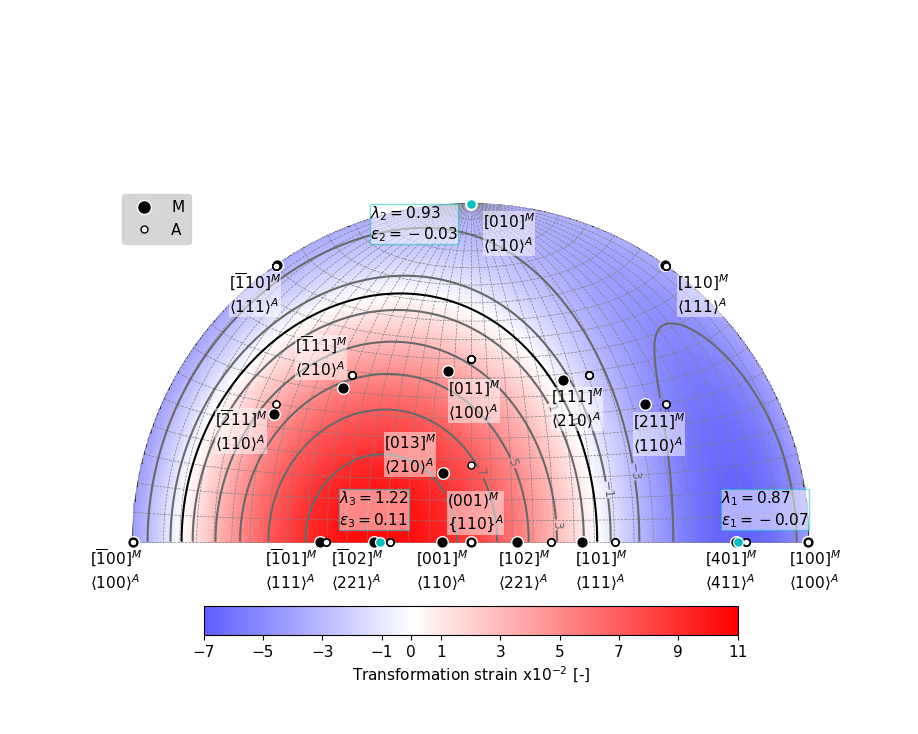

In [254]:
#size of the graph
plt.rcParams['figure.figsize'] = [22.5/2.45, 18/2.45]
SMALL_SIZE=11
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
SAVE=False
crop=True
imformats=['png','svg','pdf']
figname=f'{filepath}figures/fig03_epstrM_{ProjType}.pdf'
vmcbar=[-0.07*100,0.11*100]
vmcolmap=[-max(vmcbar),max(vmcbar)]
ticks=np.concatenate((np.linspace(-0.07,-0.01,4),[0],np.linspace(0.01,0.11,6)))*100
contourcol=['dimgray']*len(ticks)
contourcol[ticks.tolist().index(0)]='k'
cmap=get_cmap([(0,0,1),(1,1,1),(1,0,0)])
cbartitle="Transformation strain x$10^{-2}$ [-]"
data2plot={'oris':oris,
                  'colmapdata':TrStrainOrisM[0,:]*100,'cbartitle':cbartitle,'vm':vmcolmap,'vmbar':vmcbar,#'datadeviders':DataDeviders,
                  'cmap':cmap,'graphtype':'','nump':301,'contourcol':contourcol,
                  'ticks':ticks,'figsize':[16/2.45, 15/2.45]}

dirtexthifts=copy.copy(attributesM['dirtexthifts'])
normtexthifts=copy.copy(attributesM['normtexthifts'])
dirtexthifts['111']=[dirtexthifts['111'][0],dirtexthifts['111'][1]+0.3]
#'dirtexthifts':dirtexthifts}#,

dirtexthifts['-110']=[-0.25,0]
dirtexthifts['-111']=[-0.25,0.25]
dirtexthifts['-101']=[-0.15,0.]
dirtexthifts['-102']=[-0.1,0.0]
dirtexthifts['001']=[-0.03,0.0]
dirtexthifts['101']=[0.05,0.0]
dirtexthifts['-100']=[-0.1,0.0]
dirtexthifts['-211']=[-0.3,0.05]
dirtexthifts['011']=[-0.05,0.0]
dirtexthifts['111']=[-0.1,0.0]
dirtexthifts['211']=[-0.1,0.0]
dirtexthifts['013']=[-0.3,0.2]

normtexthifts['001']=[-0.02,0.25]

if not SAVE:
    attributesMadd={'dirtexthifts':dirtexthifts,'normtexthifts':normtexthifts,'printcorrespasfamily':True,'cbarhshift':-0.15,'dy1':-0.2,'dy2':-0.2}
else:
    attributesMadd={'printcorrespasfamily':True}

attributes2use4save={'dy1':-0.25}#'cbarh':0.025,'cbarhshift':-0.08})

#attributesMadd={'dirtexthifts':dirtexthifts}
EigVec=MT.StressfreeRefs['martensite space']['EigVecs']
Lambda=MT.StressfreeRefs['martensite space']['EigVals']
Var=0
withdraw=False
EigVecCor=[]

for ev in EigVec[Var].T.tolist():
    if ev[1]<0:
        EigVecCor.append([ev[0],-ev[1],ev[2]])
    else:
        EigVecCor.append(ev)

dirs,normals=gen_dirs_norms(np.eye(3), np.eye(3),EigVecCor,[], R2Proj=plotter1.R2Proj,recsymops=[],symops=[])
LambdaText=[]
for li in range(3):
    LambdaText.append(f'$\lambda_{li+1}={np.round(Lambda[Var][li],decimals=2)}$\n$\\varepsilon_{li+1}={np.round(0.5*(Lambda[Var][li]-1),decimals=2)}$')
colormapdata=None 
if SAVE:
    plt.rcParams['figure.figsize'] = data2plot['figsize']

code="""
plotter1=plotter()
for attrib in [attributes,attributesM,attributesMadd,data2plot]:
    plotter1.__dict__.update(attrib)
if not SAVE:
    plotter1.__dict__.update({'withdraw':withdraw})
    plotter1.__dict__.update({'colormapdata':colormapdata})

plotter1.plotProj()
plotter1.plotDirsNorms()
plotter1.plotColormap()
plotter1.plotColorbar()
#ToCode#plotter1.dataShow()
plotter1.dataAnnot()
plotter1.scatterDataAnnot()
plotter1.fig.texts[1].set_y(0.8)
#get contour of the zero transformation strain
for ii,path in enumerate(plotter1.contours.collections[4].get_paths()):
    if ii==0:
        contourZero=path.vertices
    else:
        contourZero=np.vstack((contourZero,path.vertices))
#fig,ax=plt.subplots()
#ax.plot(contour[:,0],contour[:,1])
#Plot eigenvectors and eigenvalues
Var=0
EigVecCor=[]
for ev in EigVec[Var].T.tolist():
    if ev[1]<0:
        EigVecCor.append([ev[0],-ev[1],ev[2]])
    else:
        EigVecCor.append(ev)
dirs,normals=gen_dirs_norms(np.eye(3), np.eye(3),EigVecCor,[], R2Proj=plotter1.R2Proj,recsymops=[],symops=[])
d2plot=[]
for d,lt in zip(dirs,LambdaText):
    if d['vector'][2]>=0 or np.abs(d['vector'][2])<1e-5:
        d2plot.append((d[plotter1.ProjType][0:2],d['uvw'],lt))
    else:
        d2plot.append((-1*d[plotter1.ProjType][0:2],d['uvw'],lt))
    
    #(d[ProjType][0:2],d['uvw']) for d in dirs if d['vector'][2]>=0 or np.abs(d['vector'][2])<1e-5]#np.array([d['equalarea'][0:2] for d in dirs if d['vector'][2]>=0 or np.abs(d['vector'][2])<1e-5])

testshifts=[[0,0] for i in d2plot]
if SAVE:
    testshifts[0]=[0.05,-0.08]
    testshifts[1]=[-0.4,-0.4]
    testshifts[2]=[-0.05,-0.08]
else:
    testshifts[0]=[0.05,-0.08]
    testshifts[1]=[-0.3,-0.3]
    testshifts[2]=[-0.05,-0.08]

for d2p,testshift in zip(d2plot,testshifts):
    if d2p[0][1]>=-1e-2:
        dy=0.15
        dx=-0.12
        plotter1.ax.scatter(d2p[0][0],d2p[0][1],c='c',s=50,edgecolors='w',alpha=1,linewidths=1, zorder=5000)
        text=d2p[2]

        tt=plotter1.ax.text(d2p[0][0]+dx+testshift[0],d2p[0][1]+dy+testshift[1],text,color='k', zorder=50000)
        tt.set_bbox(dict(boxstyle='square,pad=-0.',facecolor='white', alpha=0.5, edgecolor='c'))
        #print(text)




if SAVE:
    plt.rcParams['figure.figsize'] = data2plot['figsize']
    fname=figname.replace('_graphtype',f'_{PP[-1].graphtype}')
    plotter1.figsave(fname=fname,imformats=imformats,crop=crop)

"""
exec(code)

### Generation of executable interactive graph generated above

In [197]:
pyenvs="~/python/pyenvs/straincomp"
projectfname="plotTrStrain"
if not SAVE:
    import pickle as pickle
    toPickel={'data2plot':data2plot,'attributes':attributes,'attributesM':attributesM,'attributesMadd':attributesMadd,'colormapdata':plotter1.colormapdata,
              'figsize':plt.rcParams['figure.figsize'],'LambdaText':LambdaText,
              'EigVec':EigVec,'Lambda':Lambda,'Var':Var,'code':code.replace("'withdraw':withdraw","'withdraw':False").replace('SAVE','False').replace('#ToCode#','')}
    dirs=[f'{filepath}data/',f'{projectpath}data/']
    
    for diri in dirs:
        with open(f"{diri}{projectfname}.pckl", 'wb') as f:
            pickle.dump(toPickel, f)
    # Read in the file
    with open(projecttemplate, 'r') as file:
        filedata = file.read()
    
    # Replace the target string
    filedata = filedata.replace("datafile", f"'./data/{projectfname}.pckl'")
    
    # Write the file out again
    with open(f"{projectpath}{projectfname}.py", 'w') as file:
        file.write(filedata)
commands=f"cd {projectpath}; source {pyenvs}/bin/activate; rm -f {projectpath}{projectfname};\
pyinstaller --hidden-import matplotlib.backends --onefile --paths {pyenvs}/lib/python3.10/site-packages/ {projectpath}{projectfname}.py;\
cp {projectpath}dist/{projectfname} {projectpath};exec bash --norc"
print(commands)
!gnome-terminal -- bash -ic "{commands}"

# Sensitivity of compatibility conditions to elastic strains

## Martensite lattice space

In [255]:
#define the stress space
UniaxialStress=[500,7000]
UniaxialStress=5000
UniaxialStress=np.linspace(0,10000,21)
UniaxialStress=np.linspace(-500,500,3)
print(f"Stress space is {UniaxialStress} MPa")

Stress space is [-500.    0.  500.] MPa


In [256]:
%%time
#Create object
MT=calcMT()
#Fill in lattice matricesof austenite (LA) and martensite (LM)
MT.setLatticeMatrices(LA,LM)
#Fill in lattice correspondence
MT.setLatticeCorrespondence(Cd,CId=CId)
MT.setLatticeCorrespondencePlanes(Cp,CIp=CIp)
#Fill in tensors of elastic compliances of austenite (STA) and martensite (STM)
MT.setTensorsOfElastCompliance(STA,STM)
MT.getStressfreeDefGrads()
#We fix an austenite variant, generate orientation in martensite space and rotate it to this austenite variant for compatibility problem solution
#then the results will be visualized in martensite space by transforming orientations back to martensite space 
varsel=0
oris=MT.StressfreeDefGrads['T_MA'][:,:,varsel].dot(genori(dangle=2,hemi='upper', half='upper'))
MT.getStressfreeRefs(oris=oris)
#Solve the problem
MT.solveCompProblemWithStressOris(oris=oris,stress=UniaxialStress,vars=[varsel])
#Get solution as dictionary
Solution=MT.CurrentCompWithStressOris


CPU times: user 17.7 s, sys: 18 s, total: 35.6 s
Wall time: 11.9 s


### Loading-orientation dependence of the 2$^{nd}$ principal transformation strain $\varepsilon_2$ due to elastic strains from uniaxial loading

In [257]:
#Select stress state to plot
StressIdx=0
print(f"Plot will be for this stress: {UniaxialStress[StressIdx]}")

SyntaxError: unterminated string literal (detected at line 3) (2852496187.py, line 3)

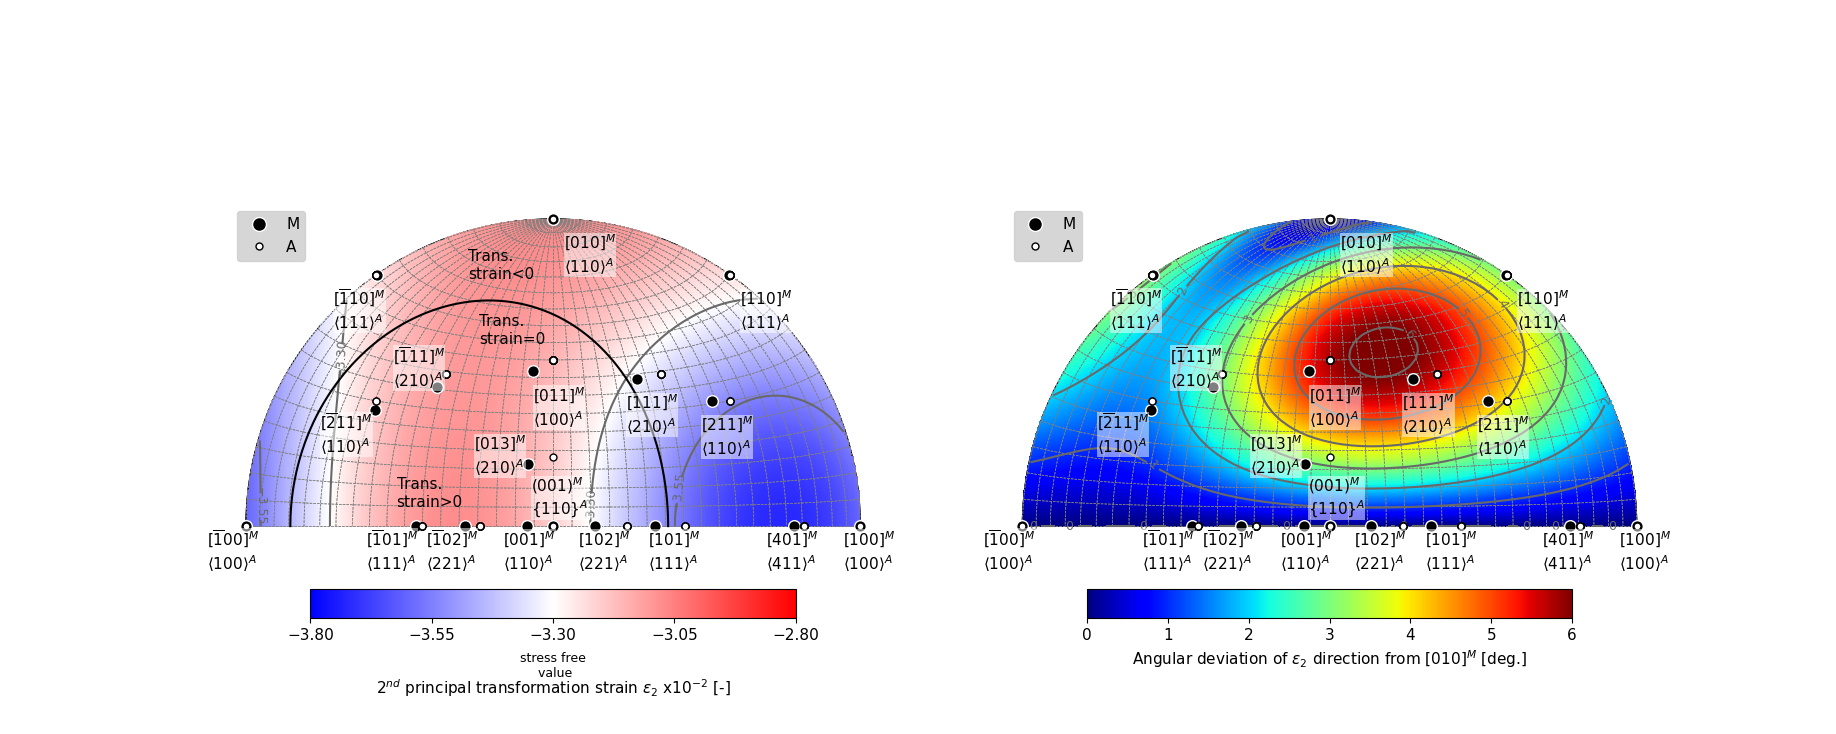

In [258]:
#size of the graph
plt.rcParams['figure.figsize'] = [45/2.45, 18/2.45]
SMALL_SIZE=11
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
SAVE=False
crop=True
imformats=['png','svg','pdf']
figname=f'{filepath}figures/'
figname+=f'fig04_eps2M_stress_{int(UniaxialStress[StressIdx])}_MPa_{ProjType}_graphtype.pdf'

vmcbar=[-0.038*100,-0.028*100]
vmcolmap=[min(vmcbar),max(vmcbar)]
ticks=np.linspace(-0.038,-0.028,5)*100
ticklabels=[str(np.around(tick,decimals=2)) for tick in ticks]
contourcol=['dimgray']*len(ticks)
#contourcol[2]='k'
cmap=get_cmap([(0,0,1),(1,1,1),(1,0,0)])
cbartitle=r"2$^{{nd}}$ principal transformation strain $\varepsilon_2$ x$10^{-2}$ [-]"

data2plot=[]
key2plot='epsilon_2'
colmap1=Solution[key2plot][StressIdx,varsel, :]*100
data2plot.append({'oris':ProjT.dot(MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(oris)),
                  'colmapdata':colmap1,'cbartitle':cbartitle,'vm':vmcolmap,
                  'vmbar':vmcbar,'cmap':cmap,'contourcol':contourcol,'ticks':ticks,
                  'graphtype':'eps2','nump':301,'figsize':[16/2.45, 15/2.45],'labelpad':25,'cbarhshift':-0.15})
vm=[0,6]
ticks=np.linspace(0,6,7)
colmap2=np.arccos(Solution['ALLEigVecs'][2,varsel, :,:,1].dot(np.array([MT.StressfreeRefs['austenite space']['EigVecs'][0][:,1]]).T))[:,0]*180/np.pi
cbartitle2=r"Angular deviation of $\varepsilon_2$ direction from [010]$^M$ [deg.]"
data2plot.append({'oris':ProjT.dot(MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(oris)),
                  'colmapdata':colmap2,
                  'cbartitle':cbartitle2,'contourcol':contourcol,'vm':vm,'ticks':ticks,
                  'graphtype':'deviation','figsize':[16/2.45, 15/2.45]})

dirtexthifts=copy.copy(attributesM['dirtexthifts'])
normtexthifts=copy.copy(attributesM['normtexthifts'])
dirtexthifts['111']=[dirtexthifts['111'][0],dirtexthifts['111'][1]+0.3]
dirtexthifts['-110']=[-0.25,0]
dirtexthifts['-111']=[-0.25,0.25]
dirtexthifts['-101']=[-0.15,0.]
dirtexthifts['-102']=[-0.1,0.0]
dirtexthifts['001']=[-0.03,0.0]
dirtexthifts['101']=[0.05,0.0]
dirtexthifts['-100']=[-0.1,0.0]
dirtexthifts['-211']=[-0.3,0.05]
dirtexthifts['011']=[-0.05,0.0]
dirtexthifts['111']=[-0.1,0.0]
dirtexthifts['211']=[-0.1,0.0]
dirtexthifts['013']=[-0.3,0.2]

normtexthifts['001']=[-0.02,0.25]

attributes2use=[]
attributes2use4save=[]
showdhalf={}
showdhalf={'showdatanames':[cbartitle,cbartitle2]
           ,'showdata':[colmap1,colmap2]}
if not SAVE:
    atributesADD={'dirtexthifts':dirtexthifts,'normtexthifts':normtexthifts,'printcorrespasfamily':True,'cbarhshift':-0.15,'dy1':-0.2}
else:
    atributesADD={'printcorrespasfamily':True,'cbarhshift':-0.15,'dy1':-0.2}
attributes2use.append([attributes,attributesM,showdhalf,atributesADD])
attributes2use.append([attributes,attributesM,showdhalf,atributesADD])
attributes2use4save.append({'dy1':-0.25})#'cbarh':0.025,'cbarhshift':-0.08})
attributes2use4save.append({'dy1':-0.25})#'cbarh':0.025,'cbarhshift':-0.08})
colormapdatas=[None,None]
withdraw=False
addvars={'stressfreetext':"stress free\n value",'colk':'k','text1':'Trans.\nstrain=0','text2':'Trans.\nstrain>0','text3':'Trans.\nstrain<0'}
code="""
PP=[]
if not SAVE:
    fig, AX = plt.subplots(1,2)
try:
    attributes2use4save
except:
    attributes2use4save=attributes2use
for data,attribs,colormapdata,attrib4save in zip(data2plot,attributes2use,colormapdatas,attributes2use4save):
    PP.append(plotter())
    for attrib in attribs:
        PP[-1].__dict__.update(attrib)
    PP[-1].__dict__.update(data)
    if not SAVE:
        PP[-1].__dict__.update({'withdraw':withdraw})
        PP[-1].__dict__.update({'colormapdata':colormapdata})
    else:
        PP[-1].__dict__.update(attrib4save)
    if not SAVE:
        PP[-1].plotProj(fig=fig,ax=AX.flatten()[len(PP)-1])
        PP[-1].plotProj()
    else:
        plt.rcParams['figure.figsize'] = PP[-1].figsize
        fig, ax = plt.subplots()
        PP[-1].plotProj(fig=fig,ax=ax)

    PP[-1].plotDirsNorms()
    PP[-1].plotColormap(nump=301)
    PP[-1].plotColorbar()
    
    
    if len(PP)==1:
        tt=PP[-1].cbar_ax.text(-3.3,-2.,addvars["stressfreetext"],color=addvars["colk"], zorder=5000,fontsize=9,horizontalalignment='center') 
        tt2=PP[-1].ax.text(np.mean(contourZero[:,0])-0.0,np.max(contourZero[:,1])-0.2,addvars["text1"],color=addvars["colk"], zorder=50000)
        tt3=PP[-1].ax.text(np.mean(contourZero[:,0])-0.38,np.max(contourZero[:,1])-0.95,addvars["text2"],color=addvars["colk"], zorder=50000)
        tt3=PP[-1].ax.text(np.mean(contourZero[:,0])-0.05,np.max(contourZero[:,1])+0.1,addvars["text3"],color=addvars["colk"], zorder=50000)

        PP[-1].ax.plot(contourZero[:,0],contourZero[:,1],'k')
    if not SAVE:
        #ToCode#PP[-1].dataShow()
        PP[-1].dataAnnot()
        PP[-1].scatterDataAnnot()
        PP[-1].fig.texts[1].set_y(0.8)
    try:
        if SAVE:
            fname=figname.replace('_graphtype',f'_{PP[-1].graphtype}')
            PP[-1].figsave(fname=fname,imformats=imformats,crop=crop)
    except:
        pass
"""
exec(code)

### Generation of executable interactive graph generated above

In [202]:
pyenvs="~/python/pyenvs/straincomp"
projectfname="plotEps2Sensitivity"
if not SAVE:
    import pickle as pickle
    colormapdata=[]
    for pp in PP:
        if pp.colormapdata is None:
            colormapdata.append(None)
        else:
            colormapdata.append([])
            for cmapdat in pp.colormapdata:
                colormapdata[-1].append(cmapdat)
    toPickel={'showdhalf':showdhalf,'data2plot':data2plot,'attributes2use':attributes2use,'colormapdatas':colormapdata,'figsize':plt.rcParams['figure.figsize'],
              'addvars':addvars,'contourZero':contourZero,'code':code.replace("'withdraw':withdraw","'withdraw':False").replace('SAVE','False').replace('#ToCode#','')}
    dirs=[f'{filepath}data/',f'{projectpath}data/']
    
    for diri in dirs:
        with open(f"{diri}{projectfname}.pckl", 'wb') as f:
            pickle.dump(toPickel, f)
    # Read in the file
    with open(projecttemplate, 'r') as file:
        filedata = file.read()
    
    # Replace the target string
    filedata = filedata.replace("datafile", f"'./data/{projectfname}.pckl'")
    
    # Write the file out again
    with open(f"{projectpath}{projectfname}.py", 'w') as file:
        file.write(filedata)
    commands=f"cd {projectpath}; source {pyenvs}/bin/activate; rm -f {projectpath}{projectfname};\
    pyinstaller --hidden-import matplotlib.backends --onefile --paths {pyenvs}/lib/python3.10/site-packages/ {projectpath}{projectfname}.py;\
    cp {projectpath}dist/{projectfname} {projectpath};exec bash --norc"
    print(commands)
    !gnome-terminal -- bash -ic "{commands}"

# Numerical solution for critical stress providing habiplane

In [259]:
SolsStress=[]
CriticalSolsStress=[]
MTSStress=[]
for UniaxialStress in [np.linspace(0,-10000,20),np.linspace(0,10000,20)]:    
    #Create object
    mt=calcMT()
    #Fill in lattice matricesof austenite (LA) and martensite (LM)
    mt.setLatticeMatrices(LA,LM)
    #Fill in lattice correspondence
    mt.setLatticeCorrespondence(Cd,CId=CId)
    mt.setLatticeCorrespondencePlanes(Cp,CIp=CIp)
    #Fill in tensors of elastic compliances of austenite (STA) and martensite (STM)
    mt.setTensorsOfElastCompliance(STA,STM)
    mt.getStressfreeDefGrads()
    #We fix an austenite variant, generate orientation in martensite space and rotate it to this austenite variant for compatibility problem Sol
    #then the results will be visualized in martensite space by transforming orientations back to martensite space 
    varsel=0
    oris=mt.StressfreeDefGrads['T_MA'][:,:,varsel].dot(genori(dangle=2,hemi='upper', half='upper'))
    mt.getStressfreeRefs(oris=oris)
    
    
    mt.setStress(UniaxialStress)
    mt.setStressSpace()
    #Solve compatibility problems 
    #Find Sols (only physically meaningfull positive deformation energy of mt)
    idxs=np.where((np.sign(mt.StressfreeRefs['austenite space']['TransformationStrain'])==np.sign(mt.stressSpace))+(np.sign(mt.stressSpace)==0))
    mt.solveCompProblemWithStressOris(idxs=idxs,vars=[varsel])
    mt.findRootsEpsilon2vsStress()
    Sol=mt.CurrentCompWithStressOris
    tol=1
    threshold =1e-5
    
    while tol>threshold:
        #Get critical Sols 
        idxs=np.where(~np.isnan(np.array([Sol['CriticalStress']])))
        mt.solveCompProblemWithStressOris(idxs=idxs,vars=[varsel],stressSpace=np.array([Sol['CriticalStress']]))
        CriticalSol = mt.CurrentCompWithStressOris
        idxs=np.where(~np.isnan(np.array([Sol['CriticalStress']])))
        tol=np.max(np.abs(CriticalSol['epsilon_2'][idxs]))
        print(f'Maximum magnitude of epsilon_2 is {tol} for a threshold of {threshold}')
        if tol<threshold:
            break
        #refine Sol
        #refine Sol considering only physically meaningfull Sols (positive deformation energy of mt)
        RefinedStressSpace=mt.refineStressspace(nsteps=10,Solution=Sol)#[::-1,:,:]
        #idxs=np.where((~np.isnan(RefinedStressSpace))*np.sign(np.dstack([mt.StressfreeRefs['austenite space']['TransformationStrain'].T]*RefinedStressSpace.shape[0]).T)==np.sign(mt.stressSpace))
        idxs=np.where(((~np.isnan(RefinedStressSpace))*(np.sign(mt.StressfreeRefs['austenite space']['TransformationStrain'])==np.sign(RefinedStressSpace)))+
                      (np.sign(RefinedStressSpace)==0))
        mt.solveCompProblemWithStressOris(idxs=idxs,vars=[varsel],stressSpace=RefinedStressSpace)
        mt.findRootsEpsilon2vsStress()
        Sol=mt.CurrentCompWithStressOris  
    
    mt.getCompatibilitySolution(Solution=Sol)
    CriticalSolsStress.append(mt.CurrentCompWithStressOris)
    SolsStress.append(Sol)
    MTSStress.append(mt)

Maximum magnitude of epsilon_2 is 0.00017760357089524614 for a threshold of 1e-05
Maximum magnitude of epsilon_2 is 2.2385665051638526e-06 for a threshold of 1e-05
Maximum magnitude of epsilon_2 is 3.260086924217198e-05 for a threshold of 1e-05
Maximum magnitude of epsilon_2 is 4.6476291581942775e-07 for a threshold of 1e-05


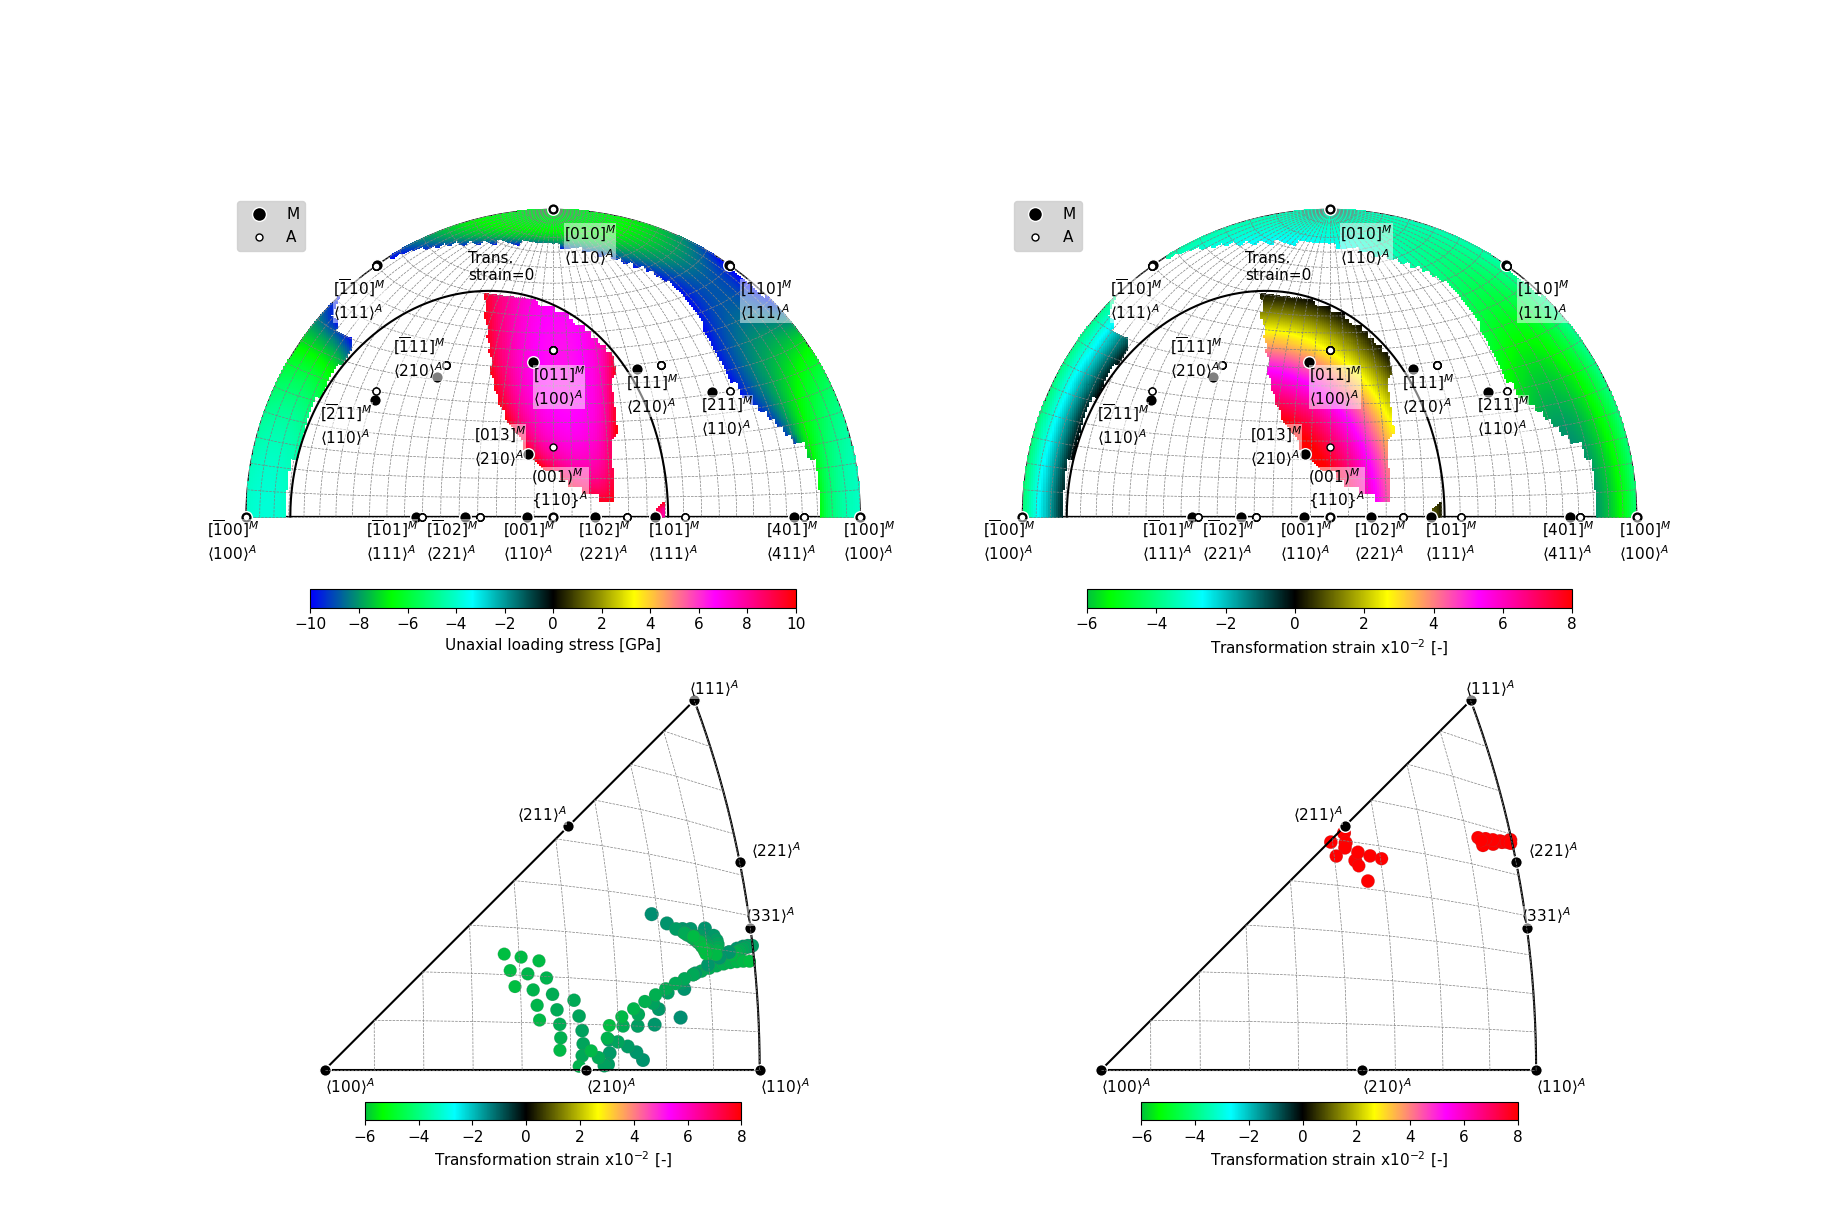

In [260]:
#size of the graph
plt.rcParams['figure.figsize'] = [45/2.45, 30/2.45]#[40/2.45, 25/2.45]
SMALL_SIZE=11
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
SAVE=False
crop=True
imformats=['png','svg','pdf']
figname=f'{filepath}figures/'

#Combine SOlutions for tension and compression
ORIS=np.array([[],[],[]])
HBP1=np.array([[],[],[]])
HBP2=np.array([[],[],[]])
HBPcolscale=np.array([])
HBPzorder=np.array([])
HBPsizescale=np.array([])
ColMap1=np.array([])
ColMap2=np.array([])
DataDeviders=[]
HBPDictIndividual=[]
scatteridxs=np.array([])
HBPDictIndividuals=[]
stresses=[] 

#lims=[[0,3,4,5,6,7],[0,4,5,6,7,8]]
for MT, CriticalSolutions, Solution, si,hbplims in zip(MTSStress,CriticalSolsStress,SolsStress,[0,1],[[6,0,3,4,5,6,7],[8,0,4,5,6,7,8]]):
    stresses.extend(MT.stress.tolist())
    #Create mask hiding orientations without solutions or without physically plausible solutions - where the transformation strain is negative for tension or positive for compression 
    mask=(np.all(Solution['epsilon_2']>0,axis=0))+\
    (np.all(Solution['epsilon_2']<0,axis=0))+\
    (np.sign(MT.StressfreeRefs['austenite space']['TransformationStrain'])!=np.sign(Solution['StressSpace'][-1,:,:]))+\
    np.isnan(Solution['CriticalStress'])    
    hbp1=CriticalSolutions['n1_a'][np.where(~mask)[0],np.where(~mask)[1],:].T
    hbp2=CriticalSolutions['n2_a'][np.where(~mask)[0],np.where(~mask)[1],:].T
    hbpcolscale=None
    hbpcolscale=MT.StressfreeRefs['austenite space']['TransformationStrain'][np.where(~mask)[0],np.where(~mask)[1]]*100
    hbpzorder=np.argsort(np.abs(hbpcolscale))[::-1]
    #hbpzorder=None
    hbpsizescale=None
    hbpsizescale=(np.abs(hbpcolscale)/np.max(np.abs(hbpcolscale)))**2*100

    HBP1=np.hstack((HBP1,hbp1))
    HBP2=np.hstack((HBP2,hbp2))
    HBPcolscale=np.hstack((HBPcolscale,hbpcolscale))
    HBPzorder=np.hstack((HBPzorder,hbpzorder))
    HBPsizescale=np.hstack((HBPsizescale,hbpsizescale))
    if len(DataDeviders)==0:
        DataDeviders.append([0,MT.oris.shape[1]])
    else:
        DataDeviders.append([DataDeviders[-1][1],DataDeviders[-1][1]+MT.oris.shape[1]+1])
    ORIS=np.hstack((ORIS,MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris)))
    if ColMap1.shape[0]==0:
        col1=np.ma.masked_array(Solution['CriticalStress'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap1=np.ma.masked_array(Solution['CriticalStress'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap2=np.ma.masked_array(MT.StressfreeRefs['austenite space']['TransformationStrain'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap3=np.ma.masked_array(CriticalSolutions['epsilon_2'],mask=mask,fill_value=np.nan)[varsel,:]
    else:
        col1=np.ma.masked_array(Solution['CriticalStress'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap1.data[np.where(~np.isnan(col1))]=col1.data[np.where(~np.isnan(col1))]
        ColMap1.mask[np.where(~np.isnan(col1))]=col1.mask[np.where(~np.isnan(col1))]
        col3=np.ma.masked_array(CriticalSolutions['epsilon_2'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap3.data[np.where(~np.isnan(col3))]=col3.data[np.where(~np.isnan(col3))]
        ColMap3.mask[np.where(~np.isnan(col3))]=col3.mask[np.where(~np.isnan(col3))]
        
    scatteridxs=np.hstack((scatteridxs,np.where(~np.isnan(np.ma.filled(col1,fill_value=np.nan)))[0]))
    #HBPDictIndividual.append({'scatterdata':[hbp1,hbp2],'scattercolscale':hbpcolscale,'scattersizescale':hbpsizescale,
    #              'scatterzorder':hbpzorder})
    HBPDictIndividual=[]
    if MT.stress[-1]<0:
        stresstype='compression'
    else:
        stresstype='tension'
    for hbplim in hbplims:
        if hbplim==10000:
            HBPDictIndividual.append({'scatterdata':[hbp1,hbp2],'scattercolscale':hbpcolscale,'scattersizescale':hbpsizescale,
                          'scatterzorder':hbpzorder,'graphtype':f'hbp_epstrlim_{hbplim}'})
        else:    
            HBPDictIndividual.append({'scatterdata':[hbp1[:,np.abs(hbpcolscale)>=hbplim],hbp2[:,np.abs(hbpcolscale)>=hbplim]],'scattercolscale':hbpcolscale[np.abs(hbpcolscale)>=hbplim],
                             'scattersizescale':hbpsizescale[np.abs(hbpcolscale)>=hbplim],
                                      'scatterzorder':np.argsort(np.abs(hbpcolscale[np.abs(hbpcolscale)>=hbplim]))[::-1],
                                     'graphtype':f'hbp_{stresstype}_trans_strain_lowlim_{hbplim}'})
        
    HBPDictIndividuals.append(HBPDictIndividual)
ColMap1=np.ma.filled(ColMap1,fill_value=np.nan)
ColMap2=np.ma.filled(ColMap2,fill_value=np.nan)
ColMap3=np.ma.filled(ColMap3,fill_value=np.nan)
HBPDict={'scatterdata':[HBP1,HBP2],'scattercolscale':HBPcolscale,'scattersizescale':HBPsizescale,
                  'scatterzorder':None,'scatteridxs':list(scatteridxs)}#HBPzorder.astype(int)}
figname+=f'fig05_criticalStressM_{ProjType}_var_{varsel}__tensioncompression_min_{int(np.nanmin(stresses))}_max_{int(np.nanmax(stresses))}_MPa_graphtype.pdf'

#Plotting data
data2plot=[]
attributes2use=[]
attributes2use4save=[]
#Plotting data for critical stress map
ticks=np.linspace(-10,10,11)
vm=[-10,10]
#vm=None
#ticks=None
cbartitle1="Unaxial loading stress [GPa]"
data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),#ORIS,
                  'colmapdata':1e-3*ColMap1,'printasfamily':False,
                  'cbartitle':cbartitle1,#'datadeviders':DataDeviders,
                  'cmap':get_cmap([(0,0,1),(0,1,0),(0,1,1),(0,0,0),(1,1,0),(1,0,1),(1,0,0)]),'vmbar':vm,
                  'vm':vm,'ticks':ticks,'contourcol':'None','graphtype':'critstress','figsize':[16/2.45, 15/2.45]})


dirtexthifts=copy.copy(attributesM['dirtexthifts'])
normtexthifts=copy.copy(attributesM['normtexthifts'])
dirtexthifts['111']=[dirtexthifts['111'][0],dirtexthifts['111'][1]+0.3]
dirtexthifts['-110']=[-0.25,0]
dirtexthifts['-111']=[-0.25,0.25]
dirtexthifts['-101']=[-0.15,0.]
dirtexthifts['-102']=[-0.1,0.0]
dirtexthifts['001']=[-0.03,0.0]
dirtexthifts['101']=[0.05,0.0]
dirtexthifts['-100']=[-0.1,0.0]
dirtexthifts['-211']=[-0.3,0.05]
dirtexthifts['011']=[-0.05,0.05]
dirtexthifts['111']=[-0.1,0.05]
dirtexthifts['211']=[-0.1,0.05]
dirtexthifts['013']=[-0.3,0.2]

normtexthifts['001']=[-0.02,0.25]
if not SAVE:
    attributesMadd={'dirtexthifts':dirtexthifts,'normtexthifts':normtexthifts,'cbarh':0.015,'cbarhshift':-0.08,'printPhase2First':False,
                    'printaascubicfamily':True,'printcorrespascubicfamily':True,'printcorrespasfamily':True,'dy1':-0.2,
                   'figsize':[16/2.45, 15/2.45]}
else:
    attributesMadd={'cbarh':0.015,'cbarhshift':-0.08,'printPhase2First':False,'dy1':-0.25,
                'printaascubicfamily':True,'printcorrespascubicfamily':True,'printcorrespasfamily':True,
               'figsize':[16/2.45, 15/2.45]}


#attributesMadd={'cbarh':0.015,'cbarhshift':-0.08,'printPhase2First':False,
#                'Cd':Cd[:,:,5],'Cp':Cp[:,:,5],'printaascubicfamily':True,'printcorrespascubicfamily':True,'printcorrespasfamily':True,
#               'figsize':[16/2.45, 15/2.45]}
attributes2use.append([attributes,attributesM,HBPDict,attributesMadd])
attributes2use4save.append({'cbarh':0.035,'cbarhshift':-0.15})

vm=[-6,8]
ticks=np.linspace(-6,8,8)
cbartitle2=r"Transformation strain x$10^{-2}$ [-]"
data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),
                  'colmapdata':100*ColMap2,'cbartitle':cbartitle2,'vm':[-8,8],#'datadeviders':DataDeviders,
                  'cmap':get_cmap([(0,0,1),(0,1,0),(0,1,1),(0,0,0),(1,1,0),(1,0,1),(1,0,0)]),
                  'ticks':ticks,'vm':[-8,8],'vmbar':vm,'contourcol':'None','graphtype':'transstrain','figsize':[16/2.45, 15/2.45]})

attributes2use.append([attributes,attributesM,HBPDict,attributesMadd])
attributes2use4save.append(attributes2use4save[-1])
if SAVE:
    figsize=[10/2.45,10/2.45]
else:
    figsize=[14/2.45,15/2.45]


dirs=copy.copy(attributesA['dirs'])
dirs.append([1,0,2])
dirs.append([3,1,3])

for HBPDictI1,HBPDictI2 in zip(HBPDictIndividuals[0],HBPDictIndividuals[1]):
    for HBPDictI in [HBPDictI1,HBPDictI2]:
        data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),#ORIS,
                          'colmapdata':100*ColMap2,'cbartitle':r"Transformation strain x$10^{-2}$ [-]",'vm':[-8,8],
                          'plotmap':False,'scatterplot':True,
                          'cmap':get_cmap([(0,0,1),(0,1,0),(0,1,1),(0,0,0),(1,1,0),(1,0,1),(1,0,0)]),
                          'vm':[-8,8],'scattercolscalevm':[-8,8],'vmbar':[-6,8],
                             'scattercolscaleticks':ticks,'figsize':figsize,'scatteredgecolors':'dimgray','scatterlinewidth':0.1,
                          'scatteridxs':list(scatteridxs),'graphtype':HBPDictI['graphtype']})
                        
        attributesMadd={'cbarh':0.015,'cbarhshift':-0.04,'printascubicfamily':True,'dirs':dirs}
        attributes2use.append([attributes,attributesA,HBPDictI,attributesMadd])
        attributes2use4save.append({'cbarh':0.025,'cbarhshift':-0.08})
ticks=np.linspace(-10,10,11)
vm=[-10,10]
vm=[-0.5,2]
ticks=np.linspace(-0.5,2,6)
cbartitle1=r"$\varepsilon_2$ $x10^{-6}$ [-]"
data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),#ORIS,
                  'colmapdata':1e6*ColMap3,'printasfamily':False,
                  'cbartitle':cbartitle1,#'datadeviders':DataDeviders,
                  'cmap':'jet','vmbar':vm,
                  'vm':vm,'ticks':ticks,'contourcol':'None','graphtype':'epsilon2','figsize':[16/2.45, 15/2.45]})
attributesMadd={'cbarh':0.015,'cbarhshift':-0.08,'printPhase2First':False,'dy1':-0.25,
            'printaascubicfamily':True,'printcorrespascubicfamily':True,'printcorrespasfamily':True,
           'figsize':[16/2.45, 15/2.45]}
attributes2use.append([attributes,attributesM,HBPDict,attributesMadd])
attributes2use4save.append({'cbarh':0.035,'cbarhshift':-0.15})

#Plotting
showdataidxs=[0,1]
showdata=[]
showdatanames=[]
for idx in showdataidxs:
    showdatanames.append(data2plot[idx]['cbartitle'])
    showdata.append(data2plot[idx]['colmapdata'])
showdat={}
showdhalf={'showdatanames':showdatanames,'showdata':showdata}


colormapdatas=[None]*len(attributes2use4save)#,None,None,None]
withdraw=True
addvars={'text1':'Trans.\nstrain=0'}

code="""
if not SAVE:
    fig, AX = plt.subplots(2,2)
try:
    attributes2use4save
except:
    attributes2use4save=attributes2use
    
PP=[]   
for data,attribs,attribs2,colormapdata in zip(data2plot,attributes2use,attributes2use4save,colormapdatas):
    if not SAVE:
        try:
            AX.flatten()[len(PP)]
        except:
            break
    PP.append(plotter())
    for attrib in attribs:
        PP[-1].__dict__.update(attrib)
    #plotter1.__dict__.update(HBPDict)
    if SAVE:
        PP[-1].__dict__.update(attribs2)
    PP[-1].__dict__.update(data)
    if not SAVE:
        PP[-1].__dict__.update({'ax2annot':[AX.flatten()[2],AX.flatten()[3]]})
        PP[-1].__dict__.update({'ax2annotcompres':[AX.flatten()[2]]})
        PP[-1].__dict__.update({'ax2annottension':[AX.flatten()[3]]})
        PP[-1].__dict__.update({'withdraw':withdraw})
        PP[-1].__dict__.update({'colormapdata':colormapdata})

        PP[-1].plotProj(fig=fig,ax=AX.flatten()[len(PP)-1])
    else:
        plt.rcParams['figure.figsize'] = PP[-1].figsize
        fig, ax = plt.subplots()
        PP[-1].plotProj(fig=fig,ax=ax)
        
    PP[-1].plotDirsNorms()
    
    PP[-1].plotColormap(nump=301)
    PP[-1].processScatterData()
    if PP[-1].scatterplot:
        PP[-1].plotScatter()#cmap=cmap,vmbar=vmbar,vm=vm,ticks=ticks,scattercolscalevm=vm)    
    PP[-1].plotColorbar()
    if PP[-1].sphere=="half":
        tt2=PP[-1].ax.text(np.mean(contourZero[:,0])-0.05,np.max(contourZero[:,1])+0.05,addvars['text1'],color='k', zorder=50000)
        PP[-1].ax.plot(contourZero[:,0],contourZero[:,1],'k')
        PP[-1].__dict__.update(showdhalf)
    if not SAVE:
        #ToCode#PP[-1].dataShow()
        PP[-1].scatterDataAnnot()
        PP[-1].dataAnnot()
        PP[-1].onpressActivate()
    if SAVE:
        fname=figname.replace('_graphtype',f'_{PP[-1].graphtype}')
        PP[-1].figsave(fname=fname,imformats=imformats,crop=crop)
if not SAVE:
    for idxi in [-1,-2]:
        PP[idxi].scatterdata=PP[0].scatterdata    
        PP[idxi].processScatterData()
        PP[idxi].scattercolscale=PP[0].scattercolscale
        #PP[idxi].scattereqhkl=PP[0].scattereqhkl    
"""
exec(code)

### Generation of executable interactive graph generated above

In [208]:
pyenvs="~/python/pyenvs/straincomp"
projectfname="plotCriticalStress"

if not SAVE:
    import pickle as pickle
    colormapdata=[]
    for pp in PP:
        if pp.colormapdata is None:
            colormapdata.append(None)
        else:
            colormapdata.append([])
            for cmapdat in pp.colormapdata:
                colormapdata[-1].append(cmapdat)
    toPickel={'showdhalf':showdhalf,'data2plot':data2plot,'attributes2use':attributes2use,'colormapdatas':colormapdata,'figsize':plt.rcParams['figure.figsize'],
              'addvars':addvars,'contourZero':contourZero,'code':code.replace("'withdraw':withdraw","'withdraw':False").replace('SAVE','False').replace('#ToCode#','')}
    dirs=[f'{filepath}data/',f'{projectpath}data/']
    
    for diri in dirs:
        with open(f"{diri}{projectfname}.pckl", 'wb') as f:
            pickle.dump(toPickel, f)
    # Read in the file
    with open(projecttemplate, 'r') as file:
        filedata = file.read()
    
    # Replace the target string
    filedata = filedata.replace("datafile", f"'./data/{projectfname}.pckl'")
    
    # Write the file out again
    with open(f"{projectpath}{projectfname}.py", 'w') as file:
        file.write(filedata)
    commands=f"cd {projectpath}; source {pyenvs}/bin/activate; rm -f {projectpath}{projectfname};\
    pyinstaller --hidden-import matplotlib.backends --onefile --paths {pyenvs}/lib/python3.10/site-packages/ {projectpath}{projectfname}.py;\
    cp {projectpath}dist/{projectfname} {projectpath};exec bash --norc"
    print(commands)
    !gnome-terminal -- bash -ic "{commands}"


# Critical C' softenning for habiplane to exist under fixed magnitude of uniaxial stress

In [261]:
SolsCp=[]
CriticalSolsCp=[]
MTSCp=[]
for UniaxialStress in [-500,500]:
    #Create computational object
    mt=calcMT()
    #Fill in lattice matricesof austenite (LA) and martensite (LM)
    mt.setLatticeMatrices(LA,LM)
    #Fill in lattice correspondence
    mt.setLatticeCorrespondence(Cd,CId=CId)
    #Fill in tensors of elastic compliances of austenite (STA) and martensite (STM)
    mt.setTensorsOfElastCompliance(STA,STM)
    mt.getStressfreeDefGrads()
    #We fix an austenite variant, generate orientation in martensite space and rotate it to this austenite variant for compatibility problem solution
    #then the results will be visualized in martensite space by transforming orientations back to martensite space 
    varsel=0
    oris=mt.StressfreeDefGrads['T_MA'][:,:,varsel].dot(genori(dangle=2,hemi='upper', half='upper'))
    
    mt.getStressfreeRefs(oris=oris)
    mt.setStress(UniaxialStress)
    #generate list of softenned elastic constants for C'=Cpmin..Cpmax
    mt.generateSTspace(numst=20, Cpmin=0.5e3, Cpmax=10e3)
    #Find solutions (only physically meaningfull positive deformation energy of MT)
    print(mt.stress)
    idxs=np.where((np.sign(np.dstack([mt.StressfreeRefs['austenite space']['TransformationStrain'].T]*mt.CP.shape[0]).T)==np.sign(mt.stress)))
    mt.solveCompProblemWithCpOris(idxs=idxs,vars=[varsel])
    mt.findRootsEpsilon2vsCp()
    Sol=mt.CurrentCompWithCpOris
    tol=1.
    threshold=1e-5
    while tol>threshold:
        #refine solution
        #Get critical solutions 
        idxs=np.where(~np.isnan(np.array([Sol['CriticalCp']])))
        mt.solveCompProblemWithCpOris(idxs=idxs,vars=[varsel],CPspace=np.array([Sol['CriticalCp']]))
        CriticalSol = mt.CurrentCompWithCpOris
        tol=np.max(np.abs(CriticalSol['epsilon_2'][idxs])) 
        print(f'Maximum magnitude of epsilon_2 is {tol} for a threshold of {threshold}')
        if tol<threshold:
            break
        RefinedCPspace=mt.refineCpspace(nsteps=10, Solution=Sol)
        #idxs=np.where((~np.isnan(RefinedCPspace))*np.sign(np.dstack([MT.StressfreeRefs['austenite space']['TransformationStrain'].T]*RefinedCPspace.shape[0]).T)==np.sign(MT.stress))
        idxs=np.where((~np.isnan(RefinedCPspace)))
        mt.solveCompProblemWithCpOris(idxs=idxs,vars=[varsel], CPspace=RefinedCPspace)
        mt.findRootsEpsilon2vsCp()
        Sol=mt.CurrentCompWithCpOris
    mt.getCompatibilitySolution(Solution=Sol,Cp=True)
    CriticalSolsCp.append(mt.CurrentCompWithCpOris)
    SolsCp.append(Sol)
    MTSCp.append(mt)

-500
Maximum magnitude of epsilon_2 is 0.008073191706699512 for a threshold of 1e-05
Maximum magnitude of epsilon_2 is 0.00020999956013473264 for a threshold of 1e-05
Maximum magnitude of epsilon_2 is 2.691255262199377e-06 for a threshold of 1e-05
500
Maximum magnitude of epsilon_2 is 0.008297117765588169 for a threshold of 1e-05
Maximum magnitude of epsilon_2 is 0.00019541826161295628 for a threshold of 1e-05
Maximum magnitude of epsilon_2 is 2.5228992192039e-06 for a threshold of 1e-05


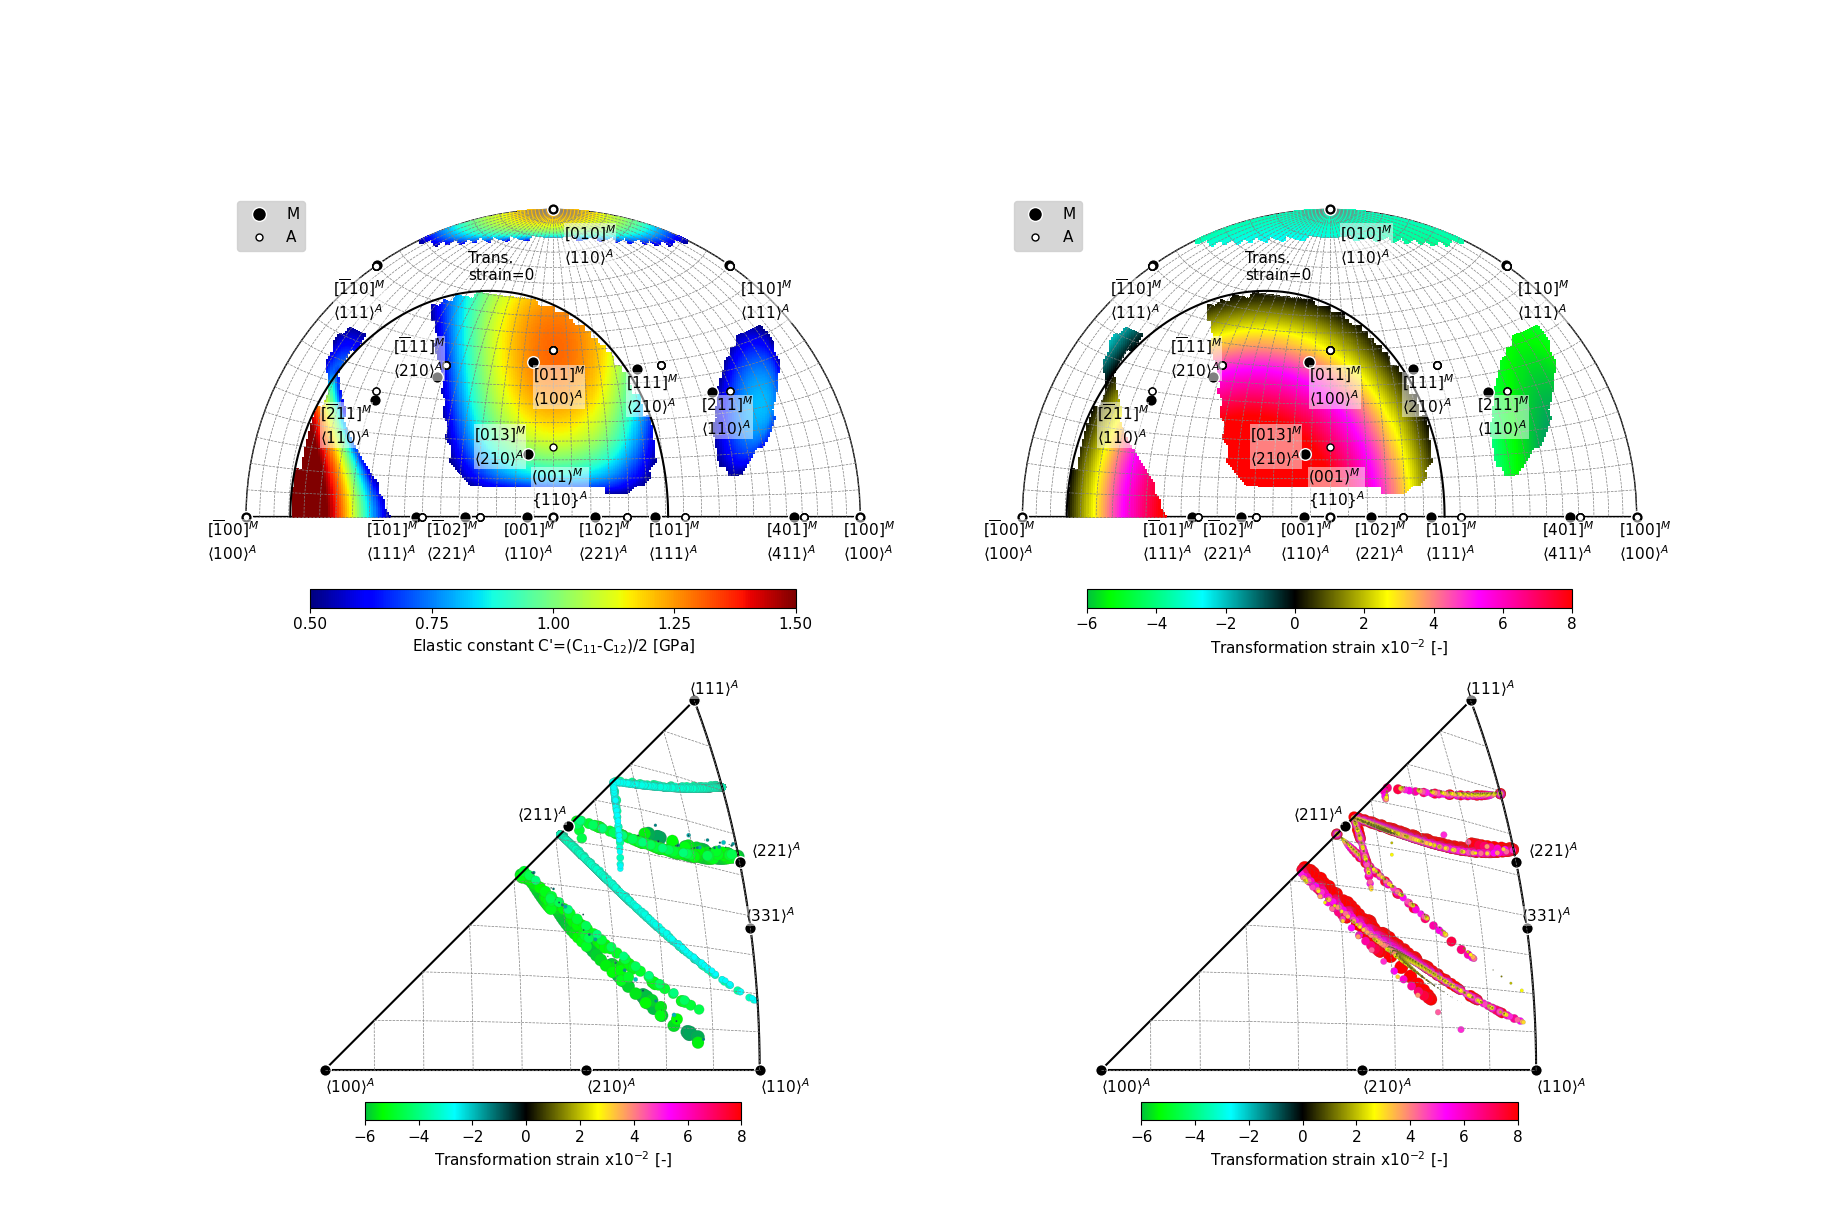

In [262]:
#size of the graph
plt.rcParams['figure.figsize'] = [45/2.45, 30/2.45]
SMALL_SIZE=11
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
SAVE=False
crop=True
imformats=['png','svg','pdf']
figname=f'{filepath}figures/'

#Combine SOlutions for tension and compression
ORIS=np.array([[],[],[]])
HBP1=np.array([[],[],[]])
HBP2=np.array([[],[],[]])
HBPcolscale=np.array([])
HBPzorder=np.array([])
HBPsizescale=np.array([])
ColMap1=np.array([])
ColMap2=np.array([])
DataDeviders=[]
HBPDictIndividual=[]
scatteridxs=np.array([])
HBPDictIndividuals=[]
stresses=[]        

for MT, CriticalSolutions, Solution, si,hbplims in zip(MTSCp,CriticalSolsCp,SolsCp,[0,1],[[0,1,2,3,4,5,6],[0,5,6,7,8,9,10]]):
    stresses.append(MT.stress)
    #Create mask hiding orientations without solutions or without physically plausible solutions - where the transformation strain is negative for tension or positive for compression 
    mask=(np.all(Solution['epsilon_2']>0,axis=0))+\
     (np.all(Solution['epsilon_2']<0,axis=0))+\
     (np.sign(MT.StressfreeRefs['austenite space']['TransformationStrain'])!=np.sign(MT.stress))+\
    np.isnan(Solution['CriticalCp'])

    hbp1=CriticalSolutions['n1_a'][np.where(~mask)[0],np.where(~mask)[1],:].T
    hbp2=CriticalSolutions['n2_a'][np.where(~mask)[0],np.where(~mask)[1],:].T
    hbpcolscale=None
    hbpcolscale=MT.StressfreeRefs['austenite space']['TransformationStrain'][np.where(~mask)[0],np.where(~mask)[1]]*100
    #print(hbpcolscale)
    hbpzorder=np.argsort(np.abs(hbpcolscale))[::-1]
    #hbpzorder=None
    hbpsizescale=None
    hbpsizescale=(np.abs(hbpcolscale)/np.max(np.abs(hbpcolscale)))**2*100

    HBP1=np.hstack((HBP1,hbp1))
    HBP2=np.hstack((HBP2,hbp2))
    HBPcolscale=np.hstack((HBPcolscale,hbpcolscale))
    HBPzorder=np.hstack((HBPzorder,hbpzorder))
    HBPsizescale=np.hstack((HBPsizescale,hbpsizescale))
    if len(DataDeviders)==0:
        DataDeviders.append([0,MT.oris.shape[1]])
    else:
        DataDeviders.append([DataDeviders[-1][1],DataDeviders[-1][1]+MT.oris.shape[1]+1])
    ORIS=np.hstack((ORIS,MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris)))
    if ColMap1.shape[0]==0:        
        col1=np.ma.masked_array(Solution['CriticalCp'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap1=np.ma.masked_array(Solution['CriticalCp'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap2=np.ma.masked_array(MT.StressfreeRefs['austenite space']['TransformationStrain'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap3=np.ma.masked_array(CriticalSolutions['epsilon_2'],mask=mask,fill_value=np.nan)[varsel,:]
    else:
        col1=np.ma.masked_array(Solution['CriticalCp'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap1.data[np.where(~np.isnan(col1))]=col1.data[np.where(~np.isnan(col1))]
        ColMap1.mask[np.where(~np.isnan(col1))]=col1.mask[np.where(~np.isnan(col1))]
        col3=np.ma.masked_array(CriticalSolutions['epsilon_2'],mask=mask,fill_value=np.nan)[varsel,:]
        ColMap3.data[np.where(~np.isnan(col3))]=col3.data[np.where(~np.isnan(col3))]
        ColMap3.mask[np.where(~np.isnan(col3))]=col3.mask[np.where(~np.isnan(col3))]

    scatteridxs=np.hstack((scatteridxs,np.where(~np.isnan(np.ma.filled(col1,fill_value=np.nan)))[0]))
    #HBPDictIndividual.append({'scatterdata':[hbp1,hbp2],'scattercolscale':hbpcolscale,'scattersizescale':hbpsizescale,
    #              'scatterzorder':hbpzorder})
    HBPDictIndividual=[]
    if MT.stress<0:
        stresstype='compression'
    else:
        stresstype='tension'
    for hbplim in hbplims:
        if hbplim==10000:
            HBPDictIndividual.append({'scatterdata':[hbp1,hbp2],'scattercolscale':hbpcolscale,'scattersizescale':hbpsizescale,
                          'scatterzorder':hbpzorder,'graphtype':f'hbp_epstrlim_{hbplim}'})
        else:    
            HBPDictIndividual.append({'scatterdata':[hbp1[:,np.abs(hbpcolscale)>=hbplim],hbp2[:,np.abs(hbpcolscale)>=hbplim]],'scattercolscale':hbpcolscale[np.abs(hbpcolscale)>=hbplim],
                             'scattersizescale':hbpsizescale[np.abs(hbpcolscale)>=hbplim],
                                      'scatterzorder':np.argsort(np.abs(hbpcolscale[np.abs(hbpcolscale)>=hbplim]))[::-1],
                                     'graphtype':f'hbp_{stresstype}_trans_strain_lowlim_{hbplim}'})
        
    HBPDictIndividuals.append(HBPDictIndividual)
ColMap1=np.ma.filled(ColMap1,fill_value=np.nan)
ColMap2=np.ma.filled(ColMap2,fill_value=np.nan)
ColMap3=np.ma.filled(ColMap3,fill_value=np.nan)
HBPDict={'scatterdata':[HBP1,HBP2],'scattercolscale':HBPcolscale,'scattersizescale':HBPsizescale,
                  'scatterzorder':None,'scatteridxs':list(scatteridxs)}#HBPzorder.astype(int)}

figname+=f'fig06_criticalCpM_{ProjType}_var_{varsel}__tensioncompression_minCp_{int(np.nanmin(MT.CP))}_max_{int(np.nanmax(MT.CP))}_MPa_graphtype.pdf'

#Plotting data
data2plot=[]
attributes2use=[]
attributes2use4save=[]
#Plotting data for C' softening
vm=[0.5,1.5]
ticks=np.linspace(0.5,1.5,5)

#vm=None
#ticks=None
cbartitle1="Elastic constant C'=(C$_{11}$-C$_{12}$)/2 [GPa]"
data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),#ORIS,
                  'colmapdata':1e-3*ColMap1,'printasfamily':False,
                  'cbartitle':cbartitle1,#'datadeviders':DataDeviders,
                  'cmap':'jet','vmbar':vm,
                  'vm':vm,'ticks':ticks,'contourcol':'None','graphtype':'critstress','figsize':[16/2.45, 15/2.45]})

dirtexthifts=copy.copy(attributesM['dirtexthifts'])
normtexthifts=copy.copy(attributesM['normtexthifts'])
dirtexthifts['111']=[dirtexthifts['111'][0],dirtexthifts['111'][1]+0.3]
dirtexthifts['-110']=[-0.25,0]
dirtexthifts['-111']=[-0.25,0.25]
dirtexthifts['-101']=[-0.15,0.]
dirtexthifts['-102']=[-0.1,0.0]
dirtexthifts['001']=[-0.03,0.0]
dirtexthifts['101']=[0.05,0.0]
dirtexthifts['-100']=[-0.1,0.0]
dirtexthifts['-211']=[-0.3,0.05]
dirtexthifts['011']=[-0.05,0.05]
dirtexthifts['111']=[-0.1,0.05]
dirtexthifts['211']=[-0.1,0.05]
dirtexthifts['013']=[-0.3,0.2]

normtexthifts['001']=[-0.02,0.25]
if not SAVE:
    attributesMadd={'dirtexthifts':dirtexthifts,'normtexthifts':normtexthifts,'cbarh':0.015,'cbarhshift':-0.08,'printPhase2First':False,
                    'printaascubicfamily':True,'printcorrespascubicfamily':True,'printcorrespasfamily':True,'dy1':-0.2,
                   'figsize':[16/2.45, 15/2.45]}
else:
    attributesMadd={'cbarh':0.015,'cbarhshift':-0.08,'printPhase2First':False,'dy1':-0.25,
                'printaascubicfamily':True,'printcorrespascubicfamily':True,'printcorrespasfamily':True,
               'figsize':[16/2.45, 15/2.45]}

attributes2use.append([attributes,attributesM,HBPDict,attributesMadd])
attributes2use4save.append({'cbarh':0.035,'cbarhshift':-0.15})

vm=[-6,8]
ticks=np.linspace(-6,8,8)
cbartitle2=r"Transformation strain x$10^{-2}$ [-]"
data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),
                  'colmapdata':100*ColMap2,'cbartitle':cbartitle2,'vm':[-8,8],#'datadeviders':DataDeviders,
                  'cmap':get_cmap([(0,0,1),(0,1,0),(0,1,1),(0,0,0),(1,1,0),(1,0,1),(1,0,0)]),
                  'ticks':ticks,'vm':[-8,8],'vmbar':vm,'contourcol':'None','graphtype':'transstrain','figsize':[16/2.45, 15/2.45]})

attributes2use.append([attributes,attributesM,HBPDict,attributesMadd])
attributes2use4save.append(attributes2use4save[-1])
if SAVE:
    figsize=[10/2.45,10/2.45]
else:
    figsize=[14/2.45,15/2.45]
dirs=copy.copy(attributesA['dirs'])
dirs.append([1,0,2])
dirs.append([3,1,3])

for HBPDictI1,HBPDictI2 in zip(HBPDictIndividuals[0],HBPDictIndividuals[1]):
    for HBPDictI in [HBPDictI1,HBPDictI2]:
        data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),#ORIS,
                          'colmapdata':100*ColMap2,'cbartitle':r"Transformation strain x$10^{-2}$ [-]",'vm':[-8,8],
                          'plotmap':False,'scatterplot':True,
                          'cmap':get_cmap([(0,0,1),(0,1,0),(0,1,1),(0,0,0),(1,1,0),(1,0,1),(1,0,0)]),
                          'vm':[-8,8],'scattercolscalevm':[-8,8],'vmbar':[-6,8],
                             'scattercolscaleticks':ticks,'figsize':figsize,'scatteredgecolors':'dimgray','scatterlinewidth':0.1,
                          'scatteridxs':list(scatteridxs),'graphtype':HBPDictI['graphtype']})
                        
        attributesMadd={'cbarh':0.015,'cbarhshift':-0.04,'printascubicfamily':True,'dirs':dirs}
        attributes2use.append([attributes,attributesA,HBPDictI,attributesMadd])
        attributes2use4save.append({'cbarh':0.025,'cbarhshift':-0.08})


vm=[-2,0.5]
ticks=np.linspace(-2,0.5,6)
cbartitle1=r"$\varepsilon_2$ $x10^{-6}$ [-]"
data2plot.append({'oris':MT.StressfreeDefGrads['T_AM'][:,:,varsel].dot(MT.oris),#ORIS,
                  'colmapdata':1e6*ColMap3,'printasfamily':False,
                  'cbartitle':cbartitle1,#'datadeviders':DataDeviders,
                  'cmap':'jet','vmbar':vm,
                  'vm':vm,'ticks':ticks,'contourcol':'None','graphtype':'epsilon2','figsize':[16/2.45, 15/2.45]})
attributesMadd={'cbarh':0.015,'cbarhshift':-0.08,'printPhase2First':False,'dy1':-0.25,
            'printaascubicfamily':True,'printcorrespascubicfamily':True,'printcorrespasfamily':True,
           'figsize':[16/2.45, 15/2.45]}
attributes2use.append([attributes,attributesM,HBPDict,attributesMadd])
attributes2use4save.append({'cbarh':0.035,'cbarhshift':-0.15})

#Plotting
showdataidxs=[0,1]
showdata=[]
showdatanames=[]
for idx in showdataidxs:
    showdatanames.append(data2plot[idx]['cbartitle'])
    showdata.append(data2plot[idx]['colmapdata'])
showdat={}
showdhalf={'showdatanames':showdatanames,'showdata':showdata}

colormapdatas=[None]*len(attributes2use4save)#,None,None,None]
withdraw=True
addvars={'text1':'Trans.\nstrain=0'}


code="""
if not SAVE:
    fig, AX = plt.subplots(2,2)
try:
    attributes2use4save
except:
    attributes2use4save=attributes2use
PP=[]    
for data,attribs,attribs2,colormapdata in zip(data2plot,attributes2use,attributes2use4save,colormapdatas):

    if not SAVE:
        try:
            AX.flatten()[len(PP)]
        except:
            break

    PP.append(plotter())
    for attrib in attribs:
        PP[-1].__dict__.update(attrib)
    #plotter1.__dict__.update(HBPDict)
    if SAVE:
        PP[-1].__dict__.update(attribs2)
    PP[-1].__dict__.update(data)
    if not SAVE:
        PP[-1].__dict__.update({'ax2annot':[AX.flatten()[2],AX.flatten()[3]]})
        PP[-1].__dict__.update({'ax2annotcompres':[AX.flatten()[2]]})
        PP[-1].__dict__.update({'ax2annottension':[AX.flatten()[3]]})
        PP[-1].__dict__.update({'withdraw':withdraw})
        PP[-1].__dict__.update({'colormapdata':colormapdata})
        PP[-1].plotProj(fig=fig,ax=AX.flatten()[len(PP)-1])
    else:
        plt.rcParams['figure.figsize'] = PP[-1].figsize
        fig, ax = plt.subplots()
        PP[-1].plotProj(fig=fig,ax=ax)
        
    PP[-1].plotDirsNorms()
    
    PP[-1].plotColormap(nump=301)
    PP[-1].processScatterData()
    if PP[-1].scatterplot:
        PP[-1].plotScatter()#cmap=cmap,vmbar=vmbar,vm=vm,ticks=ticks,scattercolscalevm=vm)    
    PP[-1].plotColorbar()
    if PP[-1].sphere=="half":
        tt2=PP[-1].ax.text(np.mean(contourZero[:,0])-0.05,np.max(contourZero[:,1])+0.05,addvars['text1'],color='k', zorder=50000)
        PP[-1].ax.plot(contourZero[:,0],contourZero[:,1],'k')
    PP[-1].__dict__.update(showdhalf)
    if not SAVE:
        #ToCode#PP[-1].dataShow()
        PP[-1].scatterDataAnnot()
        PP[-1].dataAnnot()
    if SAVE:
        fname=figname.replace('_graphtype',f'_{PP[-1].graphtype}')
        PP[-1].figsave(fname=fname,imformats=imformats,crop=crop)
if not SAVE:
    for idxi in [-1,-2]:
        PP[idxi].scatterdata=PP[0].scatterdata    
        PP[idxi].processScatterData()
        PP[idxi].scattercolscale=PP[0].scattercolscale
        #PP[idxi].scattereqhkl=PP[0].scattereqhkl    
"""
exec(code)

### Generation of executable interactive graph generated above

In [214]:
pyenvs="~/python/pyenvs/straincomp"
projectfname="plotCriticalCp"

if not SAVE:
    import pickle as pickle
    colormapdata=[]
    for pp in PP:
        if pp.colormapdata is None:
            colormapdata.append(None)
        else:
            colormapdata.append([])
            for cmapdat in pp.colormapdata:
                colormapdata[-1].append(cmapdat)
    toPickel={'showdhalf':showdhalf,'data2plot':data2plot,'attributes2use':attributes2use,'colormapdatas':colormapdata,'figsize':plt.rcParams['figure.figsize'],
              'addvars':addvars,'contourZero':contourZero,'code':code.replace("'withdraw':withdraw","'withdraw':False").replace('SAVE','False').replace('#ToCode#','')}
    dirs=[f'{filepath}data/',f'{projectpath}data/']
    
    for diri in dirs:
        with open(f"{diri}{projectfname}.pckl", 'wb') as f:
            pickle.dump(toPickel, f)
    # Read in the file
    with open(projecttemplate, 'r') as file:
        filedata = file.read()
    
    # Replace the target string
    filedata = filedata.replace("datafile", f"'./data/{projectfname}.pckl'")
    
    # Write the file out again
    with open(f"{projectpath}{projectfname}.py", 'w') as file:
        file.write(filedata)
    commands=f"cd {projectpath}; source {pyenvs}/bin/activate; rm -f {projectpath}{projectfname};\
    pyinstaller --hidden-import matplotlib.backends --onefile --paths {pyenvs}/lib/python3.10/site-packages/ {projectpath}{projectfname}.py;\
    cp {projectpath}dist/{projectfname} {projectpath};exec bash --norc"
    print(commands)
    !gnome-terminal -- bash -ic "{commands}"
